## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 0.07817939
RMSE of after m4 0.07870821
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 0.1477848
RMSE of after m4 0.14640383
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 0.089379124
RMSE of after m4 0.09203076
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 0.090026364
RMSE of after m4 0.09087419
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 0.01690196
RMSE of after m4 0.017224463
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 0.011024926
RMSE of after m4 0.011710198
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 0.009375972
RMSE of after m4 0.009957707
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 0.010425117
RMSE of after m4 0.010811509
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 0.0113804

RMSE of after m1 0.019503085
RMSE of after m3 0.0453351
RMSE of after m4 0.04697608
RMSE of after m0 0.020469714
RMSE of after m1 0.0204879
RMSE of after m3 0.04678819
RMSE of after m4 0.047302023
RMSE of after m0 0.020873852
RMSE of after m1 0.024717608
RMSE of after m3 0.042464074
RMSE of after m4 0.043437213
RMSE of after m0 0.022970745
RMSE of after m1 0.02456015
RMSE of after m3 0.045265682
RMSE of after m4 0.04574689
RMSE of after m0 0.018848438
RMSE of after m1 0.023211105
RMSE of after m3 0.034769718
RMSE of after m4 0.033027027
RMSE of after m0 0.018118193
RMSE of after m1 0.023512002
RMSE of after m3 0.017699838
RMSE of after m4 0.017087316
RMSE of after m0 0.016410066
RMSE of after m1 0.01951677
RMSE of after m3 0.022396846
RMSE of after m4 0.02111449
RMSE of after m0 0.017455647
RMSE of after m1 0.01914478
RMSE of after m3 0.022819554
RMSE of after m4 0.02123006
RMSE of after m0 0.018019704
RMSE of after m1 0.023479847
RMSE of after m3 0.025513444
RMSE of after m4 0.0238743

RMSE of after m4 0.026728526
RMSE of after m0 0.008264428
RMSE of after m1 0.008884719
RMSE of after m3 0.021267114
RMSE of after m4 0.018795334
RMSE of after m0 0.008901663
RMSE of after m1 0.010224619
RMSE of after m3 0.062440302
RMSE of after m4 0.055803232
RMSE of after m0 0.009965528
RMSE of after m1 0.012832162
RMSE of after m3 0.0349172
RMSE of after m4 0.041043214
RMSE of after m0 0.007769289
RMSE of after m1 0.010653146
RMSE of after m3 0.015672643
RMSE of after m4 0.017647358
RMSE of after m0 0.0073662754
RMSE of after m1 0.011420626
RMSE of after m3 0.012706639
RMSE of after m4 0.016428765
RMSE of after m0 0.007691673
RMSE of after m1 0.010866899
RMSE of after m3 0.030715112
RMSE of after m4 0.028068818
RMSE of after m0 0.009188379
RMSE of after m1 0.01126226
RMSE of after m3 0.046931546
RMSE of after m4 0.046942905
RMSE of after m0 0.009206981
RMSE of after m1 0.010321087
RMSE of after m3 0.021522813
RMSE of after m4 0.023335833
RMSE of after m0 0.009089295
RMSE of after m1

RMSE of after m3 0.031142008
RMSE of after m4 0.037250686
RMSE of after m0 0.009928764
RMSE of after m1 0.01743332
RMSE of after m3 0.034847375
RMSE of after m4 0.040584046
RMSE of after m0 0.011274203
RMSE of after m1 0.0181804
RMSE of after m3 0.040568523
RMSE of after m4 0.038152777
RMSE of after m0 0.011598024
RMSE of after m1 0.019761857
RMSE of after m3 0.034429133
RMSE of after m4 0.033912905
RMSE of after m0 0.011153616
RMSE of after m1 0.020894913
RMSE of after m3 0.022418616
RMSE of after m4 0.0274773
RMSE of after m0 0.011041366
RMSE of after m1 0.020269161
RMSE of after m3 0.040740844
RMSE of after m4 0.051601768
RMSE of after m0 0.009642856
RMSE of after m1 0.019698292
RMSE of after m3 0.022923147
RMSE of after m4 0.037553277
RMSE of after m0 0.011028593
RMSE of after m1 0.020748742
RMSE of after m3 0.018467074
RMSE of after m4 0.029399283
RMSE of after m0 0.012415374
RMSE of after m1 0.022186898
RMSE of after m3 0.019374954
RMSE of after m4 0.030764654
RMSE of after m0 0.

RMSE of after m1 0.017937321
RMSE of after m3 0.08763799
RMSE of after m4 0.09637416
RMSE of after m0 0.009799912
RMSE of after m1 0.0155734345
RMSE of after m3 0.032114375
RMSE of after m4 0.043002214
RMSE of after m0 0.010033218
RMSE of after m1 0.0140898395
RMSE of after m3 0.047206182
RMSE of after m4 0.04396259
RMSE of after m0 0.009615435
RMSE of after m1 0.014609613
RMSE of after m3 0.04647881
RMSE of after m4 0.03557272
RMSE of after m0 0.009022432
RMSE of after m1 0.015966976
RMSE of after m3 0.02423286
RMSE of after m4 0.03014447
RMSE of after m0 0.008713026
RMSE of after m1 0.016538274
RMSE of after m3 0.026171276
RMSE of after m4 0.032175366
RMSE of after m0 0.008398364
RMSE of after m1 0.015229495
RMSE of after m3 0.031487763
RMSE of after m4 0.036435038
RMSE of after m0 0.0090480335
RMSE of after m1 0.014638865
RMSE of after m3 0.050107878
RMSE of after m4 0.052477825
RMSE of after m0 0.009691318
RMSE of after m1 0.013402803
RMSE of after m3 0.06698363
RMSE of after m4 0.

RMSE of after m1 0.018809507
RMSE of after m3 0.03318651
RMSE of after m4 0.032446977
RMSE of after m0 0.015913796
RMSE of after m1 0.021988934
RMSE of after m3 0.022390405
RMSE of after m4 0.021270161
RMSE of after m0 0.0158993
RMSE of after m1 0.024429772
RMSE of after m3 0.023302978
RMSE of after m4 0.021938194
RMSE of after m0 0.015822968
RMSE of after m1 0.02607707
RMSE of after m3 0.023389203
RMSE of after m4 0.021747394
RMSE of after m0 0.014662178
RMSE of after m1 0.023908895
RMSE of after m3 0.023177573
RMSE of after m4 0.021903642
RMSE of after m0 0.013442555
RMSE of after m1 0.021704642
RMSE of after m3 0.027121363
RMSE of after m4 0.026245259
RMSE of after m0 0.012959587
RMSE of after m1 0.018888397
RMSE of after m3 0.023124672
RMSE of after m4 0.022454372
RMSE of after m0 0.013500286
RMSE of after m1 0.019980399
RMSE of after m3 0.020026542
RMSE of after m4 0.01958288
RMSE of after m0 0.013857472
RMSE of after m1 0.020209374
RMSE of after m3 0.021275986
RMSE of after m4 0.

RMSE of after m1 0.020064667
RMSE of after m3 0.013124324
RMSE of after m4 0.013176231
RMSE of after m0 0.023202857
RMSE of after m1 0.0214305
RMSE of after m3 0.012186888
RMSE of after m4 0.01179906
RMSE of after m0 0.02295775
RMSE of after m1 0.021528518
RMSE of after m3 0.013607966
RMSE of after m4 0.011919403
RMSE of after m0 0.022973051
RMSE of after m1 0.01990389
RMSE of after m3 0.012747013
RMSE of after m4 0.012881231
RMSE of after m0 0.021607041
RMSE of after m1 0.020362338
RMSE of after m3 0.013216416
RMSE of after m4 0.013916376
RMSE of after m0 0.022985524
RMSE of after m1 0.022307023
RMSE of after m3 0.01372775
RMSE of after m4 0.014132495
RMSE of after m0 0.020330543
RMSE of after m1 0.020920586
RMSE of after m3 0.018249054
RMSE of after m4 0.018704962
RMSE of after m0 0.019332908
RMSE of after m1 0.020132437
RMSE of after m3 0.011942611
RMSE of after m4 0.012761896
RMSE of after m0 0.02434363
RMSE of after m1 0.021246493
RMSE of after m3 0.043741573
RMSE of after m4 0.04

RMSE of after m1 0.022872934
RMSE of after m3 0.023228746
RMSE of after m4 0.022595273
RMSE of after m0 0.026628032
RMSE of after m1 0.02479923
RMSE of after m3 0.018673597
RMSE of after m4 0.01742179
RMSE of after m0 0.026026618
RMSE of after m1 0.02495142
RMSE of after m3 0.017561723
RMSE of after m4 0.016086359
RMSE of after m0 0.025678134
RMSE of after m1 0.02446927
RMSE of after m3 0.018060401
RMSE of after m4 0.016465865
RMSE of after m0 0.02597145
RMSE of after m1 0.025664922
RMSE of after m3 0.02511043
RMSE of after m4 0.023827814
RMSE of after m0 0.025419394
RMSE of after m1 0.028074667
RMSE of after m3 0.029689673
RMSE of after m4 0.027458211
RMSE of after m0 0.02462933
RMSE of after m1 0.02593623
RMSE of after m3 0.05299654
RMSE of after m4 0.051132824
RMSE of after m0 0.024240406
RMSE of after m1 0.024086094
RMSE of after m3 0.054578405
RMSE of after m4 0.05457473
RMSE of after m0 0.024246916
RMSE of after m1 0.027217617
RMSE of after m3 0.021769885
RMSE of after m4 0.02115

RMSE of after m1 0.010538659
RMSE of after m3 0.018049633
RMSE of after m4 0.018762507
RMSE of after m0 0.008983547
RMSE of after m1 0.01124075
RMSE of after m3 0.03590164
RMSE of after m4 0.033397563
RMSE of after m0 0.009062707
RMSE of after m1 0.012226181
RMSE of after m3 0.054878257
RMSE of after m4 0.05530581
RMSE of after m0 0.009342379
RMSE of after m1 0.01364898
RMSE of after m3 0.0305575
RMSE of after m4 0.033232573
RMSE of after m0 0.008316594
RMSE of after m1 0.013555133
RMSE of after m3 0.018260216
RMSE of after m4 0.022845816
RMSE of after m0 0.0073632705
RMSE of after m1 0.013775569
RMSE of after m3 0.015435446
RMSE of after m4 0.02041603
RMSE of after m0 0.008127104
RMSE of after m1 0.011454911
RMSE of after m3 0.011306661
RMSE of after m4 0.016795667
RMSE of after m0 0.0092180595
RMSE of after m1 0.013934521
RMSE of after m3 0.0527322
RMSE of after m4 0.060950715
RMSE of after m0 0.0099549135
RMSE of after m1 0.015888898
RMSE of after m3 0.03649511
RMSE of after m4 0.04

RMSE of after m3 0.027992727
RMSE of after m4 0.030039238
RMSE of after m0 0.008736889
RMSE of after m1 0.014330193
RMSE of after m3 0.022632249
RMSE of after m4 0.029155783
RMSE of after m0 0.009027241
RMSE of after m1 0.013099123
RMSE of after m3 0.026460208
RMSE of after m4 0.02782324
RMSE of after m0 0.009704613
RMSE of after m1 0.014365976
RMSE of after m3 0.025854465
RMSE of after m4 0.025244376
RMSE of after m0 0.010407115
RMSE of after m1 0.016490452
RMSE of after m3 0.020620214
RMSE of after m4 0.02524637
RMSE of after m0 0.011062472
RMSE of after m1 0.018736122
RMSE of after m3 0.02027589
RMSE of after m4 0.028439034
RMSE of after m0 0.011433368
RMSE of after m1 0.019974763
RMSE of after m3 0.03181531
RMSE of after m4 0.043561693
RMSE of after m0 0.007036466
RMSE of after m1 0.014739249
RMSE of after m3 0.023141555
RMSE of after m4 0.02645909
RMSE of after m0 0.00952454
RMSE of after m1 0.014313243
RMSE of after m3 0.030025061
RMSE of after m4 0.031427827
RMSE of after m0 0.0

RMSE of after m4 0.042608075
RMSE of after m0 0.011370251
RMSE of after m1 0.019660609
RMSE of after m3 0.026015008
RMSE of after m4 0.04184136
RMSE of after m0 0.010361853
RMSE of after m1 0.019357374
RMSE of after m3 0.016218636
RMSE of after m4 0.027420621
RMSE of after m0 0.0073630824
RMSE of after m1 0.010294827
RMSE of after m3 0.049992748
RMSE of after m4 0.05228961
RMSE of after m0 0.008146623
RMSE of after m1 0.011342621
RMSE of after m3 0.053269424
RMSE of after m4 0.043952078
RMSE of after m0 0.008453544
RMSE of after m1 0.012314353
RMSE of after m3 0.03942894
RMSE of after m4 0.035376266
RMSE of after m0 0.009124459
RMSE of after m1 0.013982297
RMSE of after m3 0.050463416
RMSE of after m4 0.0503261
RMSE of after m0 0.0079936
RMSE of after m1 0.0134815
RMSE of after m3 0.03311328
RMSE of after m4 0.035881545
RMSE of after m0 0.007854843
RMSE of after m1 0.013622818
RMSE of after m3 0.024577038
RMSE of after m4 0.031013764
RMSE of after m0 0.009814606
RMSE of after m1 0.0139

RMSE of after m0 0.024169296
RMSE of after m1 0.02047095
RMSE of after m3 0.020265004
RMSE of after m4 0.01857103
RMSE of after m0 0.026551034
RMSE of after m1 0.021636881
RMSE of after m3 0.018970279
RMSE of after m4 0.01750516
RMSE of after m0 0.024350185
RMSE of after m1 0.020316476
RMSE of after m3 0.017994989
RMSE of after m4 0.016661998
RMSE of after m0 0.026351959
RMSE of after m1 0.021061873
RMSE of after m3 0.016326945
RMSE of after m4 0.0149203595
RMSE of after m0 0.023319222
RMSE of after m1 0.020668078
RMSE of after m3 0.013459746
RMSE of after m4 0.012673025
RMSE of after m0 0.020958899
RMSE of after m1 0.02039223
RMSE of after m3 0.027213635
RMSE of after m4 0.026753424
RMSE of after m0 0.02144151
RMSE of after m1 0.019990666
RMSE of after m3 0.031809106
RMSE of after m4 0.031442408
RMSE of after m0 0.025842559
RMSE of after m1 0.021878526
RMSE of after m3 0.027333882
RMSE of after m4 0.026652345
RMSE of after m0 0.024010092
RMSE of after m1 0.019990845
RMSE of after m3 0

RMSE of after m1 0.024413086
RMSE of after m3 0.018530024
RMSE of after m4 0.01592981
RMSE of after m0 0.030773364
RMSE of after m1 0.025178945
RMSE of after m3 0.039674647
RMSE of after m4 0.039042108
RMSE of after m0 0.029855106
RMSE of after m1 0.022898035
RMSE of after m3 0.030168528
RMSE of after m4 0.028950911
RMSE of after m0 0.0277603
RMSE of after m1 0.021956677
RMSE of after m3 0.019854633
RMSE of after m4 0.01793381
RMSE of after m0 0.029669084
RMSE of after m1 0.022765158
RMSE of after m3 0.019276304
RMSE of after m4 0.017447222
RMSE of after m0 0.029876357
RMSE of after m1 0.023493519
RMSE of after m3 0.018149804
RMSE of after m4 0.015930263
RMSE of after m0 0.028178101
RMSE of after m1 0.023879189
RMSE of after m3 0.021458043
RMSE of after m4 0.019725524
RMSE of after m0 0.028083164
RMSE of after m1 0.023683403
RMSE of after m3 0.020447813
RMSE of after m4 0.018067272
RMSE of after m0 0.028324584
RMSE of after m1 0.021538213
RMSE of after m3 0.018184235
RMSE of after m4 0

RMSE of after m1 0.027450593
RMSE of after m3 0.017122598
RMSE of after m4 0.017214121
RMSE of after m0 0.020157
RMSE of after m1 0.031716477
RMSE of after m3 0.033182543
RMSE of after m4 0.033198074
RMSE of after m0 0.020138217
RMSE of after m1 0.029478375
RMSE of after m3 0.039613232
RMSE of after m4 0.04009829
RMSE of after m0 0.019770734
RMSE of after m1 0.02268882
RMSE of after m3 0.016816495
RMSE of after m4 0.01729318
RMSE of after m0 0.017721679
RMSE of after m1 0.024150405
RMSE of after m3 0.022164276
RMSE of after m4 0.022295637
RMSE of after m0 0.017307326
RMSE of after m1 0.024085354
RMSE of after m3 0.035754155
RMSE of after m4 0.036419373
RMSE of after m0 0.019168513
RMSE of after m1 0.027500441
RMSE of after m3 0.022256713
RMSE of after m4 0.022138307
RMSE of after m0 0.018942788
RMSE of after m1 0.03149239
RMSE of after m3 0.030398013
RMSE of after m4 0.032132745
RMSE of after m0 0.01742647
RMSE of after m1 0.024885917
RMSE of after m3 0.022902856
RMSE of after m4 0.024

RMSE of after m3 0.010158439
RMSE of after m4 0.024342474
RMSE of after m0 0.009752719
RMSE of after m1 0.01718333
RMSE of after m3 0.019996583
RMSE of after m4 0.02820274
RMSE of after m0 0.008871205
RMSE of after m1 0.017282361
RMSE of after m3 0.025506802
RMSE of after m4 0.029947475
RMSE of after m0 0.009398686
RMSE of after m1 0.01708696
RMSE of after m3 0.056595914
RMSE of after m4 0.05422046
RMSE of after m0 0.008899007
RMSE of after m1 0.015872892
RMSE of after m3 0.02088586
RMSE of after m4 0.025906261
RMSE of after m0 0.008761104
RMSE of after m1 0.016368514
RMSE of after m3 0.015536171
RMSE of after m4 0.027130047
RMSE of after m0 0.009735487
RMSE of after m1 0.017965624
RMSE of after m3 0.018700631
RMSE of after m4 0.030618351
RMSE of after m0 0.01093772
RMSE of after m1 0.019537734
RMSE of after m3 0.025598964
RMSE of after m4 0.036142986
RMSE of after m0 0.008230873
RMSE of after m1 0.014642079
RMSE of after m3 0.06262098
RMSE of after m4 0.054346144
RMSE of after m0 0.00

RMSE of after m1 0.017766224
RMSE of after m3 0.030543631
RMSE of after m4 0.03387107
RMSE of after m0 0.010966181
RMSE of after m1 0.019089222
RMSE of after m3 0.04073727
RMSE of after m4 0.04361463
RMSE of after m0 0.012306801
RMSE of after m1 0.021097695
RMSE of after m3 0.04101307
RMSE of after m4 0.04760127
RMSE of after m0 0.010844022
RMSE of after m1 0.020724384
RMSE of after m3 0.015551682
RMSE of after m4 0.023532765
RMSE of after m0 0.009747601
RMSE of after m1 0.01927257
RMSE of after m3 0.016555578
RMSE of after m4 0.025851637
RMSE of after m0 0.008277665
RMSE of after m1 0.016090114
RMSE of after m3 0.03220174
RMSE of after m4 0.034405574
RMSE of after m0 0.009117923
RMSE of after m1 0.016207485
RMSE of after m3 0.02620144
RMSE of after m4 0.03190128
RMSE of after m0 0.01030849
RMSE of after m1 0.017256655
RMSE of after m3 0.026862884
RMSE of after m4 0.030696806
RMSE of after m0 0.0107741775
RMSE of after m1 0.019580292
RMSE of after m3 0.03491805
RMSE of after m4 0.04099

RMSE of after m1 0.020200446
RMSE of after m3 0.03176817
RMSE of after m4 0.032453865
RMSE of after m0 0.015527466
RMSE of after m1 0.018127657
RMSE of after m3 0.017472386
RMSE of after m4 0.0171498
RMSE of after m0 0.012822218
RMSE of after m1 0.0156004885
RMSE of after m3 0.068987206
RMSE of after m4 0.069477566
RMSE of after m0 0.012968994
RMSE of after m1 0.012321927
RMSE of after m3 0.06137451
RMSE of after m4 0.061588686
RMSE of after m0 0.013141537
RMSE of after m1 0.013516434
RMSE of after m3 0.031978678
RMSE of after m4 0.03257662
RMSE of after m0 0.013220446
RMSE of after m1 0.0134969335
RMSE of after m3 0.058635503
RMSE of after m4 0.058533832
RMSE of after m0 0.0150279235
RMSE of after m1 0.022065375
RMSE of after m3 0.025588796
RMSE of after m4 0.026642736
RMSE of after m0 0.013699426
RMSE of after m1 0.020254213
RMSE of after m3 0.07012954
RMSE of after m4 0.070579834
RMSE of after m0 0.012388155
RMSE of after m1 0.012167266
RMSE of after m3 0.09133092
RMSE of after m4 0

RMSE of after m1 0.022062393
RMSE of after m3 0.011043416
RMSE of after m4 0.010281362
RMSE of after m0 0.02670467
RMSE of after m1 0.021402245
RMSE of after m3 0.012407501
RMSE of after m4 0.009992542
RMSE of after m0 0.02555936
RMSE of after m1 0.02035202
RMSE of after m3 0.013336602
RMSE of after m4 0.010951005
RMSE of after m0 0.023626415
RMSE of after m1 0.020290658
RMSE of after m3 0.01137142
RMSE of after m4 0.010238127
RMSE of after m0 0.023336362
RMSE of after m1 0.02014437
RMSE of after m3 0.012316439
RMSE of after m4 0.011046606
RMSE of after m0 0.022014454
RMSE of after m1 0.019002937
RMSE of after m3 0.011991867
RMSE of after m4 0.011695742
RMSE of after m0 0.02244685
RMSE of after m1 0.019840287
RMSE of after m3 0.011637819
RMSE of after m4 0.011016011
RMSE of after m0 0.022739872
RMSE of after m1 0.019704983
RMSE of after m3 0.010964107
RMSE of after m4 0.010123595
RMSE of after m0 0.022048533
RMSE of after m1 0.018252045
RMSE of after m3 0.011451827
RMSE of after m4 0.0

RMSE of after m1 0.024414746
RMSE of after m3 0.02006728
RMSE of after m4 0.019299213
RMSE of after m0 0.026895024
RMSE of after m1 0.027286917
RMSE of after m3 0.021455828
RMSE of after m4 0.02080095
RMSE of after m0 0.023584586
RMSE of after m1 0.025474135
RMSE of after m3 0.022001034
RMSE of after m4 0.021216013
RMSE of after m0 0.024002453
RMSE of after m1 0.024167616
RMSE of after m3 0.023341458
RMSE of after m4 0.023028184
RMSE of after m0 0.02479639
RMSE of after m1 0.024913477
RMSE of after m3 0.022228649
RMSE of after m4 0.021697322
RMSE of after m0 0.026357157
RMSE of after m1 0.0275684
RMSE of after m3 0.02364348
RMSE of after m4 0.023251345
RMSE of after m0 0.025009222
RMSE of after m1 0.030088479
RMSE of after m3 0.04256383
RMSE of after m4 0.042584334
RMSE of after m0 0.023855273
RMSE of after m1 0.023425024
RMSE of after m3 0.038766667
RMSE of after m4 0.03726411
RMSE of after m0 0.022753572
RMSE of after m1 0.025048932
RMSE of after m3 0.022842366
RMSE of after m4 0.022

RMSE of after m1 0.012134232
RMSE of after m3 0.019643042
RMSE of after m4 0.022773199
RMSE of after m0 0.0086968485
RMSE of after m1 0.013395031
RMSE of after m3 0.017907698
RMSE of after m4 0.025427949
RMSE of after m0 0.009408529
RMSE of after m1 0.014972955
RMSE of after m3 0.020712594
RMSE of after m4 0.026247656
RMSE of after m0 0.01083695
RMSE of after m1 0.011187713
RMSE of after m3 0.08225605
RMSE of after m4 0.071449324
RMSE of after m0 0.008484969
RMSE of after m1 0.010209399
RMSE of after m3 0.054520622
RMSE of after m4 0.039786328
RMSE of after m0 0.0075656
RMSE of after m1 0.009787865
RMSE of after m3 0.034036066
RMSE of after m4 0.024335038
RMSE of after m0 0.00894996
RMSE of after m1 0.009232528
RMSE of after m3 0.02638847
RMSE of after m4 0.020028898
RMSE of after m0 0.008949878
RMSE of after m1 0.011163495
RMSE of after m3 0.034884337
RMSE of after m4 0.039031688
RMSE of after m0 0.0092555
RMSE of after m1 0.01397924
RMSE of after m3 0.029572845
RMSE of after m4 0.038

RMSE of after m1 0.018643107
RMSE of after m3 0.024522373
RMSE of after m4 0.036146827
RMSE of after m0 0.011682113
RMSE of after m1 0.020407915
RMSE of after m3 0.039078705
RMSE of after m4 0.04804243
RMSE of after m0 0.010046459
RMSE of after m1 0.01429854
RMSE of after m3 0.06485185
RMSE of after m4 0.05703981
RMSE of after m0 0.009188552
RMSE of after m1 0.016417041
RMSE of after m3 0.026452977
RMSE of after m4 0.027431006
RMSE of after m0 0.007889124
RMSE of after m1 0.015605476
RMSE of after m3 0.061798934
RMSE of after m4 0.05556378
RMSE of after m0 0.009366494
RMSE of after m1 0.0139764175
RMSE of after m3 0.025761347
RMSE of after m4 0.027558502
RMSE of after m0 0.013827279
RMSE of after m1 0.019658111
RMSE of after m3 0.05139404
RMSE of after m4 0.062053666
RMSE of after m0 0.011551645
RMSE of after m1 0.017289983
RMSE of after m3 0.048911072
RMSE of after m4 0.047599602
RMSE of after m0 0.009378665
RMSE of after m1 0.014442079
RMSE of after m3 0.047388773
RMSE of after m4 0.

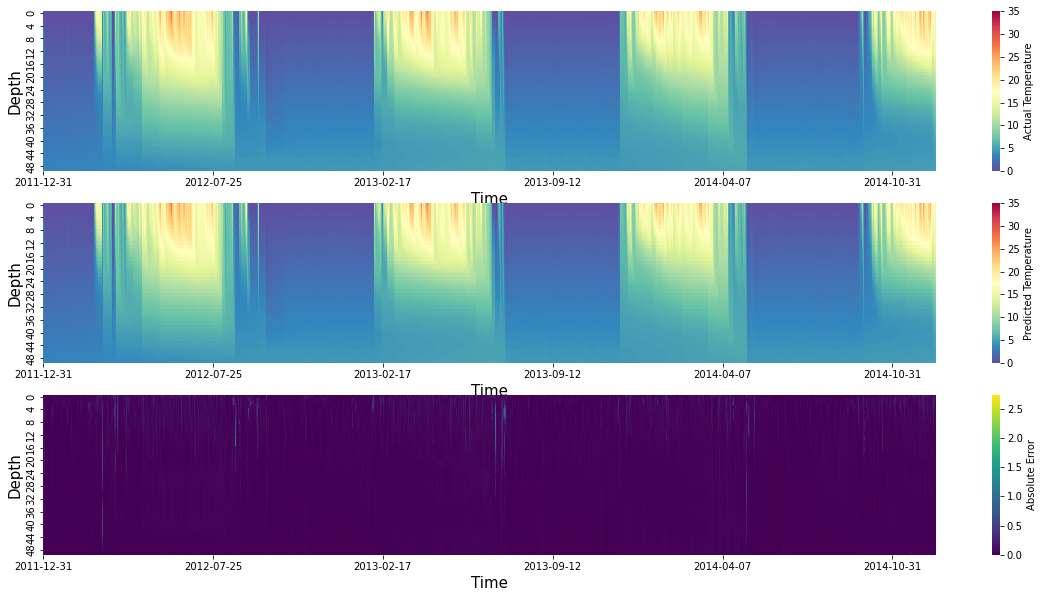

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

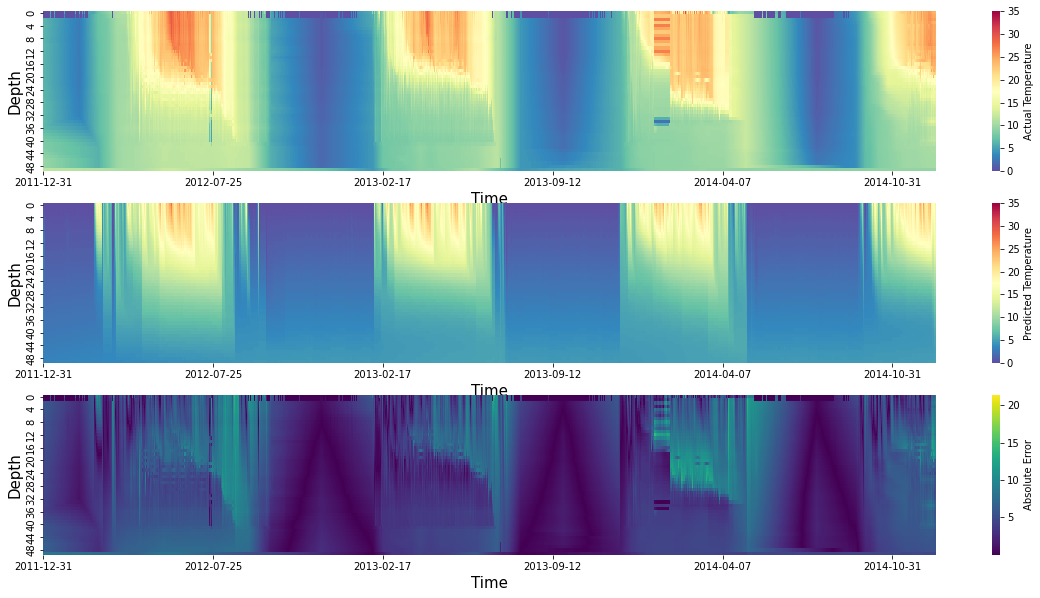

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0090550585
RMSE of after m1 0.016522184
RMSE of after m3 0.019098237
RMSE of after m4 0.02671519
RMSE of after m0 0.010058648
RMSE of after m1 0.016627615
RMSE of after m3 0.028392063
RMSE of after m4 0.03786254
RMSE of after m0 0.011175206
RMSE of after m1 0.018848468
RMSE of after m3 0.016677001
RMSE of after m4 0.028951336
RMSE of after m0 0.011941654
RMSE of after m1 0.019957943
RMSE of after m3 0.012618293
RMSE of after m4 0.020773193
RMSE of after m0 0.011727795
RMSE of after m1 0.02048253
RMSE of after m3 0.013001552
RMSE of after m4 0.021076027
RMSE of after m0 0.010224279
RMSE of after m1 0.019635735
RMSE of after m3 0.02228669
RMSE of after m4 0.025835821
RMSE of after m0 0.008626026
RMSE of after m1 0.01620574
RMSE of after m3 0.03327698
RMSE of after m4 0.031969585
RMSE of after m0 0.009490272
RMSE of after m1 0.015358796
RMSE of after m3 0.023268912
RMSE of after m4 0.027222903
RMSE of after m0 0.010674276
RMSE of after m1 0.017634274
RMSE of after m3 0.

RMSE of after m1 0.009231579
RMSE of after m3 0.07287598
RMSE of after m4 0.07176267
RMSE of after m0 0.007778761
RMSE of after m1 0.0056183287
RMSE of after m3 0.07103386
RMSE of after m4 0.045096178
RMSE of after m0 0.0108512975
RMSE of after m1 0.011498152
RMSE of after m3 0.21303876
RMSE of after m4 0.18595858
RMSE of after m0 0.012035362
RMSE of after m1 0.013494207
RMSE of after m3 0.1238379
RMSE of after m4 0.12246524
RMSE of after m0 0.010086248
RMSE of after m1 0.014489152
RMSE of after m3 0.14237873
RMSE of after m4 0.13773657
RMSE of after m0 0.010526003
RMSE of after m1 0.013280552
RMSE of after m3 0.34221125
RMSE of after m4 0.33810976
RMSE of after m0 0.0064165476
RMSE of after m1 0.007993938
RMSE of after m3 0.05402565
RMSE of after m4 0.045593947
RMSE of after m0 0.008246826
RMSE of after m1 0.009450231
RMSE of after m3 0.043960985
RMSE of after m4 0.053131826
RMSE of after m0 0.00856832
RMSE of after m1 0.008942973
RMSE of after m3 0.02275517
RMSE of after m4 0.0325825

RMSE of after m0 0.01415858
RMSE of after m1 0.015806895
RMSE of after m3 0.05068364
RMSE of after m4 0.049368124
RMSE of after m0 0.016523397
RMSE of after m1 0.014103757
RMSE of after m3 0.048098043
RMSE of after m4 0.0476903
RMSE of after m0 0.017184312
RMSE of after m1 0.016877146
RMSE of after m3 0.015500584
RMSE of after m4 0.0151804
RMSE of after m0 0.017148841
RMSE of after m1 0.018557394
RMSE of after m3 0.029311895
RMSE of after m4 0.028998638
RMSE of after m0 0.016075712
RMSE of after m1 0.0139965415
RMSE of after m3 0.028380571
RMSE of after m4 0.027951067
RMSE of after m0 0.017038234
RMSE of after m1 0.016146246
RMSE of after m3 0.030720176
RMSE of after m4 0.030191325
RMSE of after m0 0.018228516
RMSE of after m1 0.020548288
RMSE of after m3 0.06627895
RMSE of after m4 0.06618821
RMSE of after m0 0.01613603
RMSE of after m1 0.03826632
RMSE of after m3 0.052443244
RMSE of after m4 0.03510742
RMSE of after m0 0.016643256
RMSE of after m1 0.037973575
RMSE of after m3 0.05014

RMSE of after m1 0.026589442
RMSE of after m3 0.061232377
RMSE of after m4 0.057233956
RMSE of after m0 0.02648403
RMSE of after m1 0.026995642
RMSE of after m3 0.06291953
RMSE of after m4 0.058956586
RMSE of after m0 0.025414173
RMSE of after m1 0.031857744
RMSE of after m3 0.03470326
RMSE of after m4 0.03187351
RMSE of after m0 0.022569383
RMSE of after m1 0.030776136
RMSE of after m3 0.035404965
RMSE of after m4 0.03290197
RMSE of after m0 0.022294646
RMSE of after m1 0.031748474
RMSE of after m3 0.037595406
RMSE of after m4 0.034972366
RMSE of after m0 0.02064509
RMSE of after m1 0.026483301
RMSE of after m3 0.029743135
RMSE of after m4 0.027891912
RMSE of after m0 0.020849317
RMSE of after m1 0.028349517
RMSE of after m3 0.0320998
RMSE of after m4 0.029620156
RMSE of after m0 0.016641444
RMSE of after m1 0.029548403
RMSE of after m3 0.06465255
RMSE of after m4 0.060448073
RMSE of after m0 0.015140634
RMSE of after m1 0.0257595
RMSE of after m3 0.03441932
RMSE of after m4 0.0320410

RMSE of after m1 0.007961377
RMSE of after m3 0.030536588
RMSE of after m4 0.031412017
RMSE of after m0 0.008672425
RMSE of after m1 0.008255616
RMSE of after m3 0.021281173
RMSE of after m4 0.022216061
RMSE of after m0 0.008966252
RMSE of after m1 0.009039777
RMSE of after m3 0.06499166
RMSE of after m4 0.06110291
RMSE of after m0 0.007659568
RMSE of after m1 0.008296456
RMSE of after m3 0.065520376
RMSE of after m4 0.06224697
RMSE of after m0 0.0073099034
RMSE of after m1 0.008891963
RMSE of after m3 0.02460768
RMSE of after m4 0.022262093
RMSE of after m0 0.008510819
RMSE of after m1 0.01185871
RMSE of after m3 0.018754747
RMSE of after m4 0.023441626
RMSE of after m0 0.006684876
RMSE of after m1 0.008547284
RMSE of after m3 0.031248951
RMSE of after m4 0.026326047
RMSE of after m0 0.008343663
RMSE of after m1 0.008314833
RMSE of after m3 0.0294243
RMSE of after m4 0.028485026
RMSE of after m0 0.011098366
RMSE of after m1 0.009269707
RMSE of after m3 0.09279248
RMSE of after m4 0.09

RMSE of after m0 0.009241676
RMSE of after m1 0.017203923
RMSE of after m3 0.027198741
RMSE of after m4 0.034200534
RMSE of after m0 0.009590034
RMSE of after m1 0.017080458
RMSE of after m3 0.027731698
RMSE of after m4 0.035585888
RMSE of after m0 0.0091015985
RMSE of after m1 0.0143818725
RMSE of after m3 0.052935507
RMSE of after m4 0.049397785
RMSE of after m0 0.009473817
RMSE of after m1 0.016675808
RMSE of after m3 0.021931378
RMSE of after m4 0.02547168
RMSE of after m0 0.0106664235
RMSE of after m1 0.019191105
RMSE of after m3 0.03166159
RMSE of after m4 0.04037036
RMSE of after m0 0.011925627
RMSE of after m1 0.019214278
RMSE of after m3 0.048519492
RMSE of after m4 0.058957115
RMSE of after m0 0.008975551
RMSE of after m1 0.017206542
RMSE of after m3 0.02194459
RMSE of after m4 0.025779236
RMSE of after m0 0.01036379
RMSE of after m1 0.017499954
RMSE of after m3 0.034941692
RMSE of after m4 0.03739066
RMSE of after m0 0.011395493
RMSE of after m1 0.019452607
RMSE of after m3 

RMSE of after m1 0.017900372
RMSE of after m3 0.0514635
RMSE of after m4 0.05065008
RMSE of after m0 0.009526361
RMSE of after m1 0.01419841
RMSE of after m3 0.049287226
RMSE of after m4 0.043447707
RMSE of after m0 0.010422848
RMSE of after m1 0.016631389
RMSE of after m3 0.039210517
RMSE of after m4 0.04503063
RMSE of after m0 0.010735834
RMSE of after m1 0.018385341
RMSE of after m3 0.054819938
RMSE of after m4 0.0611588
RMSE of after m0 0.010221515
RMSE of after m1 0.019010188
RMSE of after m3 0.025992699
RMSE of after m4 0.039124917
RMSE of after m0 0.008593233
RMSE of after m1 0.014160954
RMSE of after m3 0.020405382
RMSE of after m4 0.033276547
RMSE of after m0 0.010008384
RMSE of after m1 0.015468521
RMSE of after m3 0.03162115
RMSE of after m4 0.04026412
RMSE of after m0 0.011067917
RMSE of after m1 0.018411197
RMSE of after m3 0.03002145
RMSE of after m4 0.044395152
RMSE of after m0 0.012541087
RMSE of after m1 0.020318244
RMSE of after m3 0.023724075
RMSE of after m4 0.04019

RMSE of after m0 0.010294792
RMSE of after m1 0.012126394
RMSE of after m3 0.038529053
RMSE of after m4 0.03599063
RMSE of after m0 0.00953863
RMSE of after m1 0.011659593
RMSE of after m3 0.037094284
RMSE of after m4 0.034533717
RMSE of after m0 0.009118008
RMSE of after m1 0.011087352
RMSE of after m3 0.038350668
RMSE of after m4 0.03618479
RMSE of after m0 0.009005261
RMSE of after m1 0.011956423
RMSE of after m3 0.10642873
RMSE of after m4 0.10435759
RMSE of after m0 0.008098314
RMSE of after m1 0.008798604
RMSE of after m3 0.107811145
RMSE of after m4 0.1109138
RMSE of after m0 0.013237107
RMSE of after m1 0.013106281
RMSE of after m3 0.15873674
RMSE of after m4 0.15958488
RMSE of after m0 0.016642407
RMSE of after m1 0.039791703
RMSE of after m3 0.12858132
RMSE of after m4 0.12850201
RMSE of after m0 0.019748256
RMSE of after m1 0.098601356
RMSE of after m3 0.14639261
RMSE of after m4 0.14782949
RMSE of after m0 0.020018876
RMSE of after m1 0.08687679
RMSE of after m3 0.1196612
R

RMSE of after m1 0.025402935
RMSE of after m3 0.027578095
RMSE of after m4 0.024483908
RMSE of after m0 0.019776493
RMSE of after m1 0.027987147
RMSE of after m3 0.032472484
RMSE of after m4 0.02903384
RMSE of after m0 0.019404164
RMSE of after m1 0.021734811
RMSE of after m3 0.037260845
RMSE of after m4 0.035511486
RMSE of after m0 0.021605097
RMSE of after m1 0.022822501
RMSE of after m3 0.027645739
RMSE of after m4 0.025425715
RMSE of after m0 0.022923574
RMSE of after m1 0.024219522
RMSE of after m3 0.024018425
RMSE of after m4 0.02196329
RMSE of after m0 0.02412193
RMSE of after m1 0.023678364
RMSE of after m3 0.024041021
RMSE of after m4 0.021829346
RMSE of after m0 0.02446734
RMSE of after m1 0.02422928
RMSE of after m3 0.02354715
RMSE of after m4 0.020927863
RMSE of after m0 0.025000107
RMSE of after m1 0.025318652
RMSE of after m3 0.025945816
RMSE of after m4 0.022854663
RMSE of after m0 0.024134621
RMSE of after m1 0.023906767
RMSE of after m3 0.025068363
RMSE of after m4 0.0

RMSE of after m1 0.007136303
RMSE of after m3 0.018582711
RMSE of after m4 0.020582253
RMSE of after m0 0.008067063
RMSE of after m1 0.006384515
RMSE of after m3 0.04274371
RMSE of after m4 0.041884214
RMSE of after m0 0.010059019
RMSE of after m1 0.008106481
RMSE of after m3 0.17208926
RMSE of after m4 0.17231679
RMSE of after m0 0.0124300625
RMSE of after m1 0.012325713
RMSE of after m3 0.03842532
RMSE of after m4 0.03793697
RMSE of after m0 0.01124705
RMSE of after m1 0.010900203
RMSE of after m3 0.07787107
RMSE of after m4 0.076422736
RMSE of after m0 0.009897156
RMSE of after m1 0.00889066
RMSE of after m3 0.19263014
RMSE of after m4 0.18987273
RMSE of after m0 0.0104162255
RMSE of after m1 0.012554957
RMSE of after m3 0.07186756
RMSE of after m4 0.07643721
RMSE of after m0 0.006782713
RMSE of after m1 0.010063887
RMSE of after m3 0.028517585
RMSE of after m4 0.032188278
RMSE of after m0 0.00799959
RMSE of after m1 0.006607002
RMSE of after m3 0.047080323
RMSE of after m4 0.045112

RMSE of after m1 0.019491473
RMSE of after m3 0.023871826
RMSE of after m4 0.035176054
RMSE of after m0 0.009594494
RMSE of after m1 0.019391032
RMSE of after m3 0.018730395
RMSE of after m4 0.027877912
RMSE of after m0 0.007592844
RMSE of after m1 0.015608353
RMSE of after m3 0.019025248
RMSE of after m4 0.027351191
RMSE of after m0 0.0085748285
RMSE of after m1 0.015475873
RMSE of after m3 0.018771311
RMSE of after m4 0.028489428
RMSE of after m0 0.009081329
RMSE of after m1 0.017991139
RMSE of after m3 0.0117427595
RMSE of after m4 0.02773533
RMSE of after m0 0.010794538
RMSE of after m1 0.018038206
RMSE of after m3 0.03841779
RMSE of after m4 0.042824674
RMSE of after m0 0.009584223
RMSE of after m1 0.014631103
RMSE of after m3 0.048289996
RMSE of after m4 0.04390852
RMSE of after m0 0.0076739066
RMSE of after m1 0.015210191
RMSE of after m3 0.027338877
RMSE of after m4 0.030320207
RMSE of after m0 0.008649034
RMSE of after m1 0.015699549
RMSE of after m3 0.046249308
RMSE of after 

RMSE of after m0 0.009527722
RMSE of after m1 0.01768768
RMSE of after m3 0.018400287
RMSE of after m4 0.026039954
RMSE of after m0 0.010438437
RMSE of after m1 0.017296122
RMSE of after m3 0.0314431
RMSE of after m4 0.038369194
RMSE of after m0 0.0109091215
RMSE of after m1 0.019634098
RMSE of after m3 0.013429893
RMSE of after m4 0.028996715
RMSE of after m0 0.012210289
RMSE of after m1 0.021388043
RMSE of after m3 0.017927848
RMSE of after m4 0.030811973
RMSE of after m0 0.009500698
RMSE of after m1 0.015555938
RMSE of after m3 0.057367265
RMSE of after m4 0.05031768
RMSE of after m0 0.009415134
RMSE of after m1 0.016936745
RMSE of after m3 0.030308511
RMSE of after m4 0.031146832
RMSE of after m0 0.008572237
RMSE of after m1 0.015685981
RMSE of after m3 0.022096328
RMSE of after m4 0.029091291
RMSE of after m0 0.009609981
RMSE of after m1 0.014021807
RMSE of after m3 0.03472547
RMSE of after m4 0.032619756
RMSE of after m0 0.010313514
RMSE of after m1 0.015626715
RMSE of after m3 0

RMSE of after m1 0.017778482
RMSE of after m3 0.02738367
RMSE of after m4 0.028963504
RMSE of after m0 0.011867977
RMSE of after m1 0.015128093
RMSE of after m3 0.07642863
RMSE of after m4 0.07561864
RMSE of after m0 0.014755511
RMSE of after m1 0.03877382
RMSE of after m3 0.18509358
RMSE of after m4 0.18521802
RMSE of after m0 0.016463367
RMSE of after m1 0.020335909
RMSE of after m3 0.082254395
RMSE of after m4 0.08228481
RMSE of after m0 0.014329076
RMSE of after m1 0.017832592
RMSE of after m3 0.022454636
RMSE of after m4 0.02188154
RMSE of after m0 0.0138608655
RMSE of after m1 0.017360456
RMSE of after m3 0.014727068
RMSE of after m4 0.0143341245
RMSE of after m0 0.015453715
RMSE of after m1 0.018924277
RMSE of after m3 0.015769586
RMSE of after m4 0.015771762
RMSE of after m0 0.01395324
RMSE of after m1 0.01643849
RMSE of after m3 0.029539054
RMSE of after m4 0.029487824
RMSE of after m0 0.013345268
RMSE of after m1 0.012882122
RMSE of after m3 0.034468986
RMSE of after m4 0.033

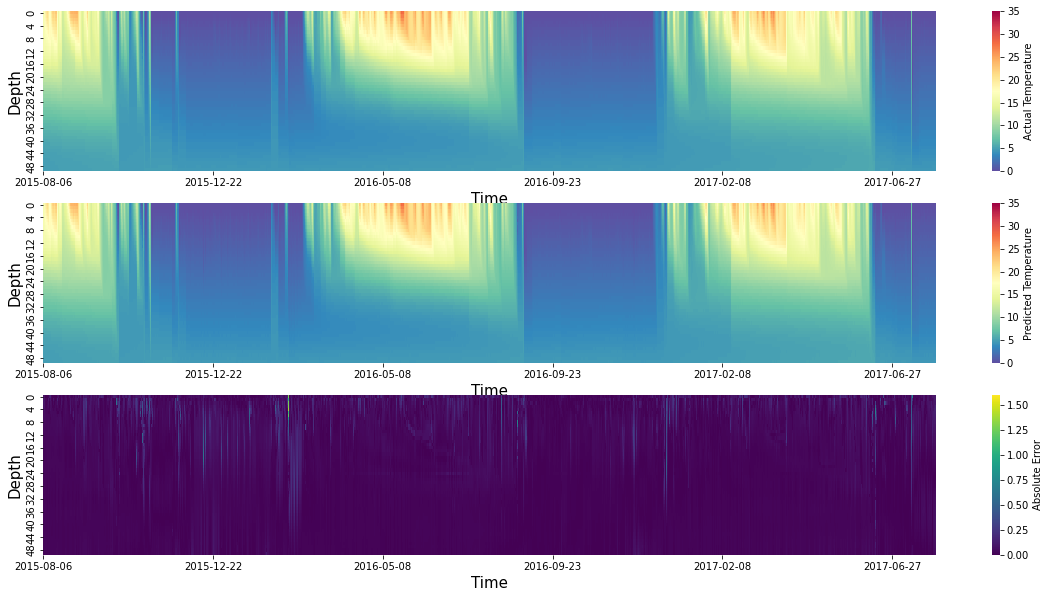

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

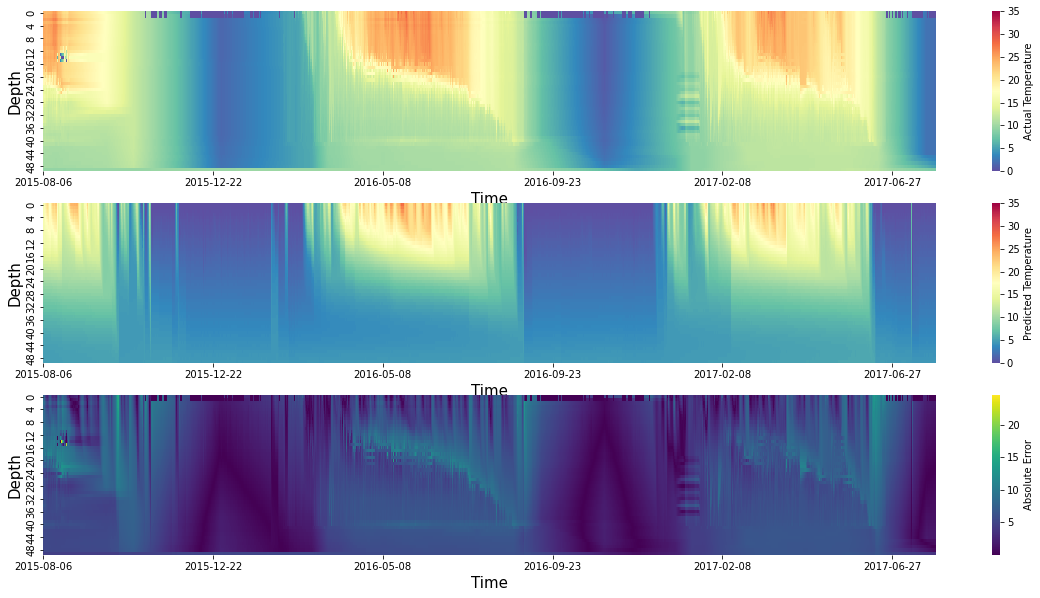

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04349529181305193, Train L2 Error: 0.0057276601087314395
Test RMSE: 0.058766599809652265, Train L2 Error: 0.007387817348391442


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.016564466585520927, Train L2 Error: 0.0021814161585095035
Test RMSE: 0.018082867571663358, Train L2 Error: 0.0022734152265340805


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014016497076078948, Train L2 Error: 0.0018445259825475508
Test RMSE: 0.01633510608431941, Train L2 Error: 0.0020521246787989266


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [34]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:07<2:08:18,  7.71s/it]

Epoch : 0, Train_loss: 0.8153895229792886, Loss m0: 1.2437386282922334e-05, Loss m1: 0.011127988924889351,  Loss m3: 0.8153895229792886, Loss m4: 1.4927743421425768e-05


  5%|▌         | 51/1000 [06:52<2:12:37,  8.39s/it]

Epoch : 50, Train_loss: 0.1480277263688063, Loss m0: 1.2437386282922334e-05, Loss m1: 0.7354451096032396,  Loss m3: 0.1480277263688063, Loss m4: 1.4927743421425768e-05


 10%|█         | 101/1000 [14:14<2:15:23,  9.04s/it]

Epoch : 100, Train_loss: 0.13229003579931803, Loss m0: 1.2437386282922334e-05, Loss m1: 0.7644155129066731,  Loss m3: 0.13229003579931803, Loss m4: 1.4927743421425768e-05


 15%|█▌        | 151/1000 [20:56<1:50:20,  7.80s/it]

Epoch : 150, Train_loss: 0.12183602772657824, Loss m0: 1.2437386282922334e-05, Loss m1: 0.7746534056498826,  Loss m3: 0.12183602772657824, Loss m4: 1.4927743421425768e-05


 20%|██        | 201/1000 [27:28<1:44:54,  7.88s/it]

Epoch : 200, Train_loss: 0.11382817831870136, Loss m0: 1.2437386282922334e-05, Loss m1: 0.785089393124499,  Loss m3: 0.11382817831870136, Loss m4: 1.4927743421425768e-05


 25%|██▌       | 251/1000 [33:58<1:36:10,  7.70s/it]

Epoch : 250, Train_loss: 0.10755606752221858, Loss m0: 1.2437386282922334e-05, Loss m1: 0.7941587280183416,  Loss m3: 0.10755606752221858, Loss m4: 1.4927743421425768e-05


 30%|███       | 301/1000 [41:00<1:54:43,  9.85s/it]

Epoch : 300, Train_loss: 0.10236151304839035, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8015099203784175,  Loss m3: 0.10236151304839035, Loss m4: 1.4927743421425768e-05


 35%|███▌      | 351/1000 [48:28<1:37:24,  9.01s/it]

Epoch : 350, Train_loss: 0.09790938583699012, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8074401132576522,  Loss m3: 0.09790938583699012, Loss m4: 1.4927743421425768e-05


 40%|████      | 401/1000 [56:20<1:35:43,  9.59s/it]

Epoch : 400, Train_loss: 0.09402671562586244, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8122040602999429,  Loss m3: 0.09402671562586244, Loss m4: 1.4927743421425768e-05


 45%|████▌     | 451/1000 [1:03:33<1:14:17,  8.12s/it]

Epoch : 450, Train_loss: 0.09057174758461549, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8161057917801344,  Loss m3: 0.09057174758461549, Loss m4: 1.4927743421425768e-05


 50%|█████     | 501/1000 [1:10:13<1:06:00,  7.94s/it]

Epoch : 500, Train_loss: 0.08748454013464592, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8196693790152301,  Loss m3: 0.08748454013464592, Loss m4: 1.4927743421425768e-05


 55%|█████▌    | 551/1000 [1:16:50<59:48,  7.99s/it]  

Epoch : 550, Train_loss: 0.08476085845275967, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8231837113384342,  Loss m3: 0.08476085845275967, Loss m4: 1.4927743421425768e-05


 60%|██████    | 601/1000 [1:23:27<52:36,  7.91s/it]

Epoch : 600, Train_loss: 0.08237662046562871, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8266952023351581,  Loss m3: 0.08237662046562871, Loss m4: 1.4927743421425768e-05


 65%|██████▌   | 651/1000 [1:30:04<45:56,  7.90s/it]

Epoch : 650, Train_loss: 0.08029930648988252, Loss m0: 1.2437386282922334e-05, Loss m1: 0.83024325298856,  Loss m3: 0.08029930648988252, Loss m4: 1.4927743421425768e-05


 70%|███████   | 701/1000 [1:36:44<39:53,  8.00s/it]

Epoch : 700, Train_loss: 0.07850652358082155, Loss m0: 1.2437386282922334e-05, Loss m1: 0.833899436752856,  Loss m3: 0.07850652358082155, Loss m4: 1.4927743421425768e-05


 75%|███████▌  | 751/1000 [1:43:12<32:02,  7.72s/it]

Epoch : 750, Train_loss: 0.07697090748104377, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8376514433968119,  Loss m3: 0.07697090748104377, Loss m4: 1.4927743421425768e-05


 80%|████████  | 801/1000 [1:49:39<25:39,  7.74s/it]

Epoch : 800, Train_loss: 0.0756481624840191, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8414243663441631,  Loss m3: 0.0756481624840191, Loss m4: 1.4927743421425768e-05


 85%|████████▌ | 851/1000 [1:56:04<19:24,  7.82s/it]

Epoch : 850, Train_loss: 0.0744958765288645, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8451362585498986,  Loss m3: 0.0744958765288645, Loss m4: 1.4927743421425768e-05


 90%|█████████ | 901/1000 [2:02:29<12:39,  7.67s/it]

Epoch : 900, Train_loss: 0.07348971370461838, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8486496308194037,  Loss m3: 0.07348971370461838, Loss m4: 1.4927743421425768e-05


 95%|█████████▌| 951/1000 [2:08:55<06:20,  7.76s/it]

Epoch : 950, Train_loss: 0.07262039335644645, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8518395309226707,  Loss m3: 0.07262039335644645, Loss m4: 1.4927743421425768e-05


100%|██████████| 1000/1000 [2:15:15<00:00,  8.12s/it]


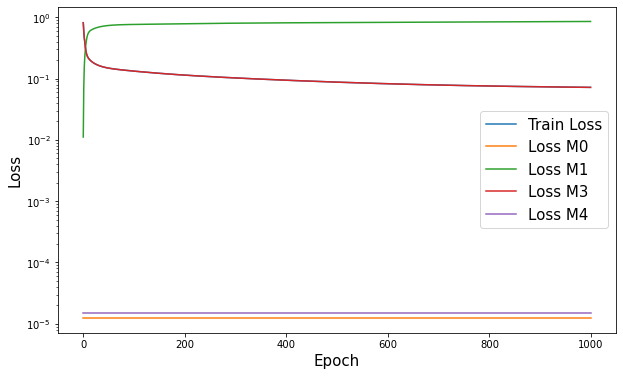

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [36]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 2.7878406
RMSE of after m4 2.4540486
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 3.41734
RMSE of after m4 3.3486347
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 4.882973
RMSE of after m4 4.7756357
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 5.0396314
RMSE of after m4 4.901795
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 5.017928
RMSE of after m4 4.8670034
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 4.912722
RMSE of after m4 4.7625556
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 4.900732
RMSE of after m4 4.7214446
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 4.902558
RMSE of after m4 4.7160206
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 4.9521375
RMSE of after m4 4.766916
RMSE 

RMSE of after m3 4.1124887
RMSE of after m4 3.7221177
RMSE of after m0 0.007792614
RMSE of after m1 0.008576836
RMSE of after m3 2.978024
RMSE of after m4 2.9329698
RMSE of after m0 0.009526869
RMSE of after m1 0.010083725
RMSE of after m3 3.390392
RMSE of after m4 3.1840096
RMSE of after m0 0.009393042
RMSE of after m1 0.011325409
RMSE of after m3 4.6313295
RMSE of after m4 3.8881416
RMSE of after m0 0.010285034
RMSE of after m1 0.013249002
RMSE of after m3 5.6103067
RMSE of after m4 4.250716
RMSE of after m0 0.009125734
RMSE of after m1 0.0137356585
RMSE of after m3 5.871786
RMSE of after m4 4.3493176
RMSE of after m0 0.008596247
RMSE of after m1 0.014596719
RMSE of after m3 6.0350504
RMSE of after m4 4.428234
RMSE of after m0 0.0072846273
RMSE of after m1 0.012779305
RMSE of after m3 6.0938077
RMSE of after m4 4.383391
RMSE of after m0 0.008523658
RMSE of after m1 0.012053964
RMSE of after m3 5.925434
RMSE of after m4 4.221562
RMSE of after m0 0.0086771995
RMSE of after m1 0.0128080

RMSE of after m1 0.010626613
RMSE of after m3 3.4630241
RMSE of after m4 3.6878562
RMSE of after m0 0.008825115
RMSE of after m1 0.013106328
RMSE of after m3 3.4598699
RMSE of after m4 3.7089443
RMSE of after m0 0.010953018
RMSE of after m1 0.015220422
RMSE of after m3 3.4422715
RMSE of after m4 3.6596043
RMSE of after m0 0.009173058
RMSE of after m1 0.014213214
RMSE of after m3 3.4144812
RMSE of after m4 3.577548
RMSE of after m0 0.010232818
RMSE of after m1 0.011256004
RMSE of after m3 3.388406
RMSE of after m4 3.565828
RMSE of after m0 0.008506172
RMSE of after m1 0.010823727
RMSE of after m3 3.3767161
RMSE of after m4 3.5909696
RMSE of after m0 0.008689203
RMSE of after m1 0.0121498145
RMSE of after m3 3.4083974
RMSE of after m4 3.6388257
RMSE of after m0 0.008408281
RMSE of after m1 0.013315908
RMSE of after m3 3.5306537
RMSE of after m4 3.8156202
RMSE of after m0 0.0135769565
RMSE of after m1 0.018992472
RMSE of after m3 3.4567232
RMSE of after m4 3.7430384
RMSE of after m0 0.008

RMSE of after m1 0.019788774
RMSE of after m3 4.0924883
RMSE of after m4 5.0762815
RMSE of after m0 0.012642037
RMSE of after m1 0.022838954
RMSE of after m3 4.062105
RMSE of after m4 5.0484357
RMSE of after m0 0.011456055
RMSE of after m1 0.022291642
RMSE of after m3 4.138166
RMSE of after m4 5.178694
RMSE of after m0 0.01173902
RMSE of after m1 0.022642896
RMSE of after m3 4.0359535
RMSE of after m4 4.991045
RMSE of after m0 0.00991457
RMSE of after m1 0.020774668
RMSE of after m3 3.9213202
RMSE of after m4 4.7716403
RMSE of after m0 0.011591311
RMSE of after m1 0.020857643
RMSE of after m3 4.1172824
RMSE of after m4 5.0714555
RMSE of after m0 0.011593412
RMSE of after m1 0.022620937
RMSE of after m3 4.239691
RMSE of after m4 5.344793
RMSE of after m0 0.010982517
RMSE of after m1 0.020978441
RMSE of after m3 4.168128
RMSE of after m4 5.262949
RMSE of after m0 0.010214393
RMSE of after m1 0.021390636
RMSE of after m3 4.1399074
RMSE of after m4 5.2517014
RMSE of after m0 0.0099554155
R

RMSE of after m1 0.0131489225
RMSE of after m3 10.975191
RMSE of after m4 9.593051
RMSE of after m0 0.011701919
RMSE of after m1 0.012099885
RMSE of after m3 11.765818
RMSE of after m4 9.970726
RMSE of after m0 0.01470194
RMSE of after m1 0.017377816
RMSE of after m3 12.262033
RMSE of after m4 10.282288
RMSE of after m0 0.0133934
RMSE of after m1 0.015240631
RMSE of after m3 12.3517685
RMSE of after m4 10.309573
RMSE of after m0 0.009054085
RMSE of after m1 0.011589202
RMSE of after m3 10.659914
RMSE of after m4 9.359664
RMSE of after m0 0.008768315
RMSE of after m1 0.010152873
RMSE of after m3 9.001783
RMSE of after m4 8.311563
RMSE of after m0 0.0077960975
RMSE of after m1 0.008814336
RMSE of after m3 8.73261
RMSE of after m4 8.243749
RMSE of after m0 0.008615068
RMSE of after m1 0.010362035
RMSE of after m3 8.412889
RMSE of after m4 7.8991337
RMSE of after m0 0.008422314
RMSE of after m1 0.009612177
RMSE of after m3 7.8165345
RMSE of after m4 7.4303293
RMSE of after m0 0.0088394135


RMSE of after m0 0.021146325
RMSE of after m1 0.02248338
RMSE of after m3 2.1777074
RMSE of after m4 2.0235693
RMSE of after m0 0.021885177
RMSE of after m1 0.021948274
RMSE of after m3 2.329781
RMSE of after m4 2.1417484
RMSE of after m0 0.020637622
RMSE of after m1 0.019526267
RMSE of after m3 2.4794369
RMSE of after m4 2.2605948
RMSE of after m0 0.019618351
RMSE of after m1 0.02607038
RMSE of after m3 2.5518513
RMSE of after m4 2.323344
RMSE of after m0 0.01833879
RMSE of after m1 0.025491625
RMSE of after m3 2.412926
RMSE of after m4 2.2085862
RMSE of after m0 0.01958034
RMSE of after m1 0.020463942
RMSE of after m3 2.405571
RMSE of after m4 2.2010698
RMSE of after m0 0.02096049
RMSE of after m1 0.020894218
RMSE of after m3 2.5734224
RMSE of after m4 2.3214304
RMSE of after m0 0.02128003
RMSE of after m1 0.020215556
RMSE of after m3 2.6399221
RMSE of after m4 2.372941
RMSE of after m0 0.02494071
RMSE of after m1 0.019729575
RMSE of after m3 2.4053028
RMSE of after m4 2.2287786
RMSE

RMSE of after m1 0.0247643
RMSE of after m3 1.6135386
RMSE of after m4 1.3393401
RMSE of after m0 0.027741553
RMSE of after m1 0.025016716
RMSE of after m3 1.5970333
RMSE of after m4 1.3277305
RMSE of after m0 0.02753644
RMSE of after m1 0.026643809
RMSE of after m3 1.6164345
RMSE of after m4 1.3443311
RMSE of after m0 0.026895829
RMSE of after m1 0.025710002
RMSE of after m3 1.9945318
RMSE of after m4 1.6056333
RMSE of after m0 0.02939299
RMSE of after m1 0.027740333
RMSE of after m3 2.0868971
RMSE of after m4 1.67835
RMSE of after m0 0.031585027
RMSE of after m1 0.027921442
RMSE of after m3 2.0566056
RMSE of after m4 1.6435599
RMSE of after m0 0.030288914
RMSE of after m1 0.028121538
RMSE of after m3 2.0582197
RMSE of after m4 1.6412597
RMSE of after m0 0.029451052
RMSE of after m1 0.026197037
RMSE of after m3 2.0282245
RMSE of after m4 1.6169894
RMSE of after m0 0.02796794
RMSE of after m1 0.026941504
RMSE of after m3 1.9628892
RMSE of after m4 1.5664643
RMSE of after m0 0.026549391

RMSE of after m1 0.009139792
RMSE of after m3 3.4756954
RMSE of after m4 3.717199
RMSE of after m0 0.0085491855
RMSE of after m1 0.00970454
RMSE of after m3 3.5463057
RMSE of after m4 3.8123507
RMSE of after m0 0.007750076
RMSE of after m1 0.010664198
RMSE of after m3 3.5677211
RMSE of after m4 3.8638122
RMSE of after m0 0.007864198
RMSE of after m1 0.0120167425
RMSE of after m3 3.5838473
RMSE of after m4 3.9252641
RMSE of after m0 0.009291564
RMSE of after m1 0.014611765
RMSE of after m3 3.5493314
RMSE of after m4 3.9215708
RMSE of after m0 0.009478546
RMSE of after m1 0.0148894545
RMSE of after m3 3.5273201
RMSE of after m4 3.8279786
RMSE of after m0 0.009362352
RMSE of after m1 0.01600249
RMSE of after m3 3.405623
RMSE of after m4 3.6500304
RMSE of after m0 0.00857767
RMSE of after m1 0.015379159
RMSE of after m3 3.1425123
RMSE of after m4 3.3627653
RMSE of after m0 0.008703747
RMSE of after m1 0.015875753
RMSE of after m3 3.0709698
RMSE of after m4 3.3261392
RMSE of after m0 0.0086

RMSE of after m1 0.014765636
RMSE of after m3 5.4284573
RMSE of after m4 6.5649405
RMSE of after m0 0.01044709
RMSE of after m1 0.017244129
RMSE of after m3 5.2951546
RMSE of after m4 6.4741707
RMSE of after m0 0.010929921
RMSE of after m1 0.017819678
RMSE of after m3 5.070858
RMSE of after m4 6.260294
RMSE of after m0 0.008751854
RMSE of after m1 0.016254261
RMSE of after m3 5.0330534
RMSE of after m4 6.2746816
RMSE of after m0 0.008736889
RMSE of after m1 0.014330193
RMSE of after m3 5.1113195
RMSE of after m4 6.2470527
RMSE of after m0 0.009027241
RMSE of after m1 0.013099123
RMSE of after m3 5.0976963
RMSE of after m4 6.2685213
RMSE of after m0 0.009704613
RMSE of after m1 0.014365976
RMSE of after m3 5.1830525
RMSE of after m4 6.3835397
RMSE of after m0 0.010407115
RMSE of after m1 0.016490452
RMSE of after m3 5.121374
RMSE of after m4 6.3496814
RMSE of after m0 0.011062472
RMSE of after m1 0.018736122
RMSE of after m3 5.0394316
RMSE of after m4 6.290981
RMSE of after m0 0.0114333

RMSE of after m0 0.010361853
RMSE of after m1 0.019357374
RMSE of after m3 4.71614
RMSE of after m4 5.5185666
RMSE of after m0 0.0073630824
RMSE of after m1 0.010294827
RMSE of after m3 4.8478913
RMSE of after m4 5.546577
RMSE of after m0 0.008146623
RMSE of after m1 0.011342621
RMSE of after m3 5.3416805
RMSE of after m4 6.064887
RMSE of after m0 0.008453544
RMSE of after m1 0.012314353
RMSE of after m3 5.4838734
RMSE of after m4 6.159293
RMSE of after m0 0.009124459
RMSE of after m1 0.013982297
RMSE of after m3 5.445229
RMSE of after m4 6.1463685
RMSE of after m0 0.0079936
RMSE of after m1 0.0134815
RMSE of after m3 5.412884
RMSE of after m4 6.121529
RMSE of after m0 0.007854843
RMSE of after m1 0.013622818
RMSE of after m3 5.374649
RMSE of after m4 6.096037
RMSE of after m0 0.009814606
RMSE of after m1 0.013907265
RMSE of after m3 5.4413714
RMSE of after m4 6.039238
RMSE of after m0 0.008148791
RMSE of after m1 0.01397041
RMSE of after m3 5.0867453
RMSE of after m4 5.7276835
RMSE of

RMSE of after m1 0.020316476
RMSE of after m3 4.341832
RMSE of after m4 3.6181867
RMSE of after m0 0.026351959
RMSE of after m1 0.021061873
RMSE of after m3 4.504314
RMSE of after m4 3.7285523
RMSE of after m0 0.023319222
RMSE of after m1 0.020668078
RMSE of after m3 4.7064767
RMSE of after m4 3.859528
RMSE of after m0 0.020958899
RMSE of after m1 0.02039223
RMSE of after m3 4.780984
RMSE of after m4 3.912192
RMSE of after m0 0.02144151
RMSE of after m1 0.019990666
RMSE of after m3 4.6583753
RMSE of after m4 3.814374
RMSE of after m0 0.025842559
RMSE of after m1 0.021878526
RMSE of after m3 4.632022
RMSE of after m4 3.7910907
RMSE of after m0 0.024010092
RMSE of after m1 0.019990845
RMSE of after m3 4.902936
RMSE of after m4 3.9357793
RMSE of after m0 0.023470923
RMSE of after m1 0.02076637
RMSE of after m3 4.5393033
RMSE of after m4 3.703657
RMSE of after m0 0.022141192
RMSE of after m1 0.02209468
RMSE of after m3 4.267753
RMSE of after m4 3.531789
RMSE of after m0 0.022363497
RMSE of

RMSE of after m3 1.1629211
RMSE of after m4 1.004485
RMSE of after m0 0.029876357
RMSE of after m1 0.023493519
RMSE of after m3 1.1547945
RMSE of after m4 0.9994801
RMSE of after m0 0.028178101
RMSE of after m1 0.023879189
RMSE of after m3 1.1591022
RMSE of after m4 1.0066015
RMSE of after m0 0.028083164
RMSE of after m1 0.023683403
RMSE of after m3 1.1383151
RMSE of after m4 0.98685294
RMSE of after m0 0.028324584
RMSE of after m1 0.021538213
RMSE of after m3 1.0695866
RMSE of after m4 0.91867065
RMSE of after m0 0.02777677
RMSE of after m1 0.02405611
RMSE of after m3 0.99327606
RMSE of after m4 0.84734917
RMSE of after m0 0.02659416
RMSE of after m1 0.022962924
RMSE of after m3 0.98958343
RMSE of after m4 0.846892
RMSE of after m0 0.025751079
RMSE of after m1 0.023706533
RMSE of after m3 0.9776866
RMSE of after m4 0.8376767
RMSE of after m0 0.024746489
RMSE of after m1 0.022154182
RMSE of after m3 1.0136712
RMSE of after m4 0.86367476
RMSE of after m0 0.02888579
RMSE of after m1 0.02

RMSE of after m1 0.024085354
RMSE of after m3 4.3662486
RMSE of after m4 3.006227
RMSE of after m0 0.019168513
RMSE of after m1 0.027500441
RMSE of after m3 4.698601
RMSE of after m4 3.2010486
RMSE of after m0 0.018942788
RMSE of after m1 0.03149239
RMSE of after m3 4.834962
RMSE of after m4 3.209743
RMSE of after m0 0.01742647
RMSE of after m1 0.024885917
RMSE of after m3 5.050383
RMSE of after m4 3.3026469
RMSE of after m0 0.016871769
RMSE of after m1 0.02916393
RMSE of after m3 5.1310987
RMSE of after m4 3.3633413
RMSE of after m0 0.0126249725
RMSE of after m1 0.018704085
RMSE of after m3 5.7036095
RMSE of after m4 5.0812716
RMSE of after m0 0.010449269
RMSE of after m1 0.010756645
RMSE of after m3 5.149285
RMSE of after m4 4.883368
RMSE of after m0 0.008510787
RMSE of after m1 0.008399841
RMSE of after m3 3.125012
RMSE of after m4 3.0315022
RMSE of after m0 0.0077182194
RMSE of after m1 0.0072943736
RMSE of after m3 2.3974602
RMSE of after m4 2.4423811
RMSE of after m0 0.008233526


RMSE of after m3 4.1207476
RMSE of after m4 4.8709164
RMSE of after m0 0.009752719
RMSE of after m1 0.01718333
RMSE of after m3 4.1355147
RMSE of after m4 4.9210105
RMSE of after m0 0.008871205
RMSE of after m1 0.017282361
RMSE of after m3 4.154785
RMSE of after m4 4.9755883
RMSE of after m0 0.009398686
RMSE of after m1 0.01708696
RMSE of after m3 4.2581425
RMSE of after m4 5.0803723
RMSE of after m0 0.008899007
RMSE of after m1 0.015872892
RMSE of after m3 4.3228273
RMSE of after m4 5.1393094
RMSE of after m0 0.008761104
RMSE of after m1 0.016368514
RMSE of after m3 4.3298736
RMSE of after m4 5.194668
RMSE of after m0 0.009735487
RMSE of after m1 0.017965624
RMSE of after m3 4.256428
RMSE of after m4 5.1276793
RMSE of after m0 0.01093772
RMSE of after m1 0.019537734
RMSE of after m3 4.145631
RMSE of after m4 5.007019
RMSE of after m0 0.008230873
RMSE of after m1 0.014642079
RMSE of after m3 4.2630415
RMSE of after m4 5.1991277
RMSE of after m0 0.008031354
RMSE of after m1 0.013931415


RMSE of after m0 0.009747601
RMSE of after m1 0.01927257
RMSE of after m3 4.6664605
RMSE of after m4 5.7537484
RMSE of after m0 0.008277665
RMSE of after m1 0.016090114
RMSE of after m3 4.9583216
RMSE of after m4 6.091093
RMSE of after m0 0.009117923
RMSE of after m1 0.016207485
RMSE of after m3 4.7741632
RMSE of after m4 5.86428
RMSE of after m0 0.01030849
RMSE of after m1 0.017256655
RMSE of after m3 4.7671566
RMSE of after m4 5.886305
RMSE of after m0 0.0107741775
RMSE of after m1 0.019580292
RMSE of after m3 4.87732
RMSE of after m4 6.0559535
RMSE of after m0 0.014640071
RMSE of after m1 0.023784285
RMSE of after m3 5.0792003
RMSE of after m4 6.4001956
RMSE of after m0 0.0065872027
RMSE of after m1 0.01790457
RMSE of after m3 4.862797
RMSE of after m4 6.0857744
RMSE of after m0 0.00908739
RMSE of after m1 0.013868371
RMSE of after m3 4.906381
RMSE of after m4 6.0752482
RMSE of after m0 0.00924576
RMSE of after m1 0.015500399
RMSE of after m3 4.9389415
RMSE of after m4 6.149431
RMSE

RMSE of after m4 7.0943537
RMSE of after m0 0.013597095
RMSE of after m1 0.019845057
RMSE of after m3 8.583836
RMSE of after m4 6.975278
RMSE of after m0 0.0126153
RMSE of after m1 0.020200446
RMSE of after m3 8.4021435
RMSE of after m4 6.866028
RMSE of after m0 0.015527466
RMSE of after m1 0.018127657
RMSE of after m3 8.655864
RMSE of after m4 7.044887
RMSE of after m0 0.012822218
RMSE of after m1 0.0156004885
RMSE of after m3 9.68769
RMSE of after m4 8.003812
RMSE of after m0 0.012968994
RMSE of after m1 0.012321927
RMSE of after m3 9.075291
RMSE of after m4 7.730787
RMSE of after m0 0.013141537
RMSE of after m1 0.013516434
RMSE of after m3 9.367577
RMSE of after m4 7.8853374
RMSE of after m0 0.013220446
RMSE of after m1 0.0134969335
RMSE of after m3 9.218894
RMSE of after m4 7.7299623
RMSE of after m0 0.0150279235
RMSE of after m1 0.022065375
RMSE of after m3 10.165792
RMSE of after m4 8.244328
RMSE of after m0 0.013699426
RMSE of after m1 0.020254213
RMSE of after m3 10.026673
RMSE

RMSE of after m1 0.018211437
RMSE of after m3 2.4357238
RMSE of after m4 2.2245042
RMSE of after m0 0.031128893
RMSE of after m1 0.01908822
RMSE of after m3 2.41428
RMSE of after m4 2.202727
RMSE of after m0 0.02599125
RMSE of after m1 0.01944554
RMSE of after m3 2.0918252
RMSE of after m4 1.9167604
RMSE of after m0 0.027647745
RMSE of after m1 0.020168068
RMSE of after m3 2.2131693
RMSE of after m4 2.0160775
RMSE of after m0 0.033193048
RMSE of after m1 0.020591151
RMSE of after m3 2.2091422
RMSE of after m4 2.0060315
RMSE of after m0 0.032588687
RMSE of after m1 0.020583844
RMSE of after m3 2.0616627
RMSE of after m4 1.8659534
RMSE of after m0 0.030336307
RMSE of after m1 0.02030105
RMSE of after m3 1.8772591
RMSE of after m4 1.6976393
RMSE of after m0 0.03008013
RMSE of after m1 0.019806942
RMSE of after m3 1.68121
RMSE of after m4 1.5287614
RMSE of after m0 0.026295824
RMSE of after m1 0.020571476
RMSE of after m3 1.6494234
RMSE of after m4 1.5029796
RMSE of after m0 0.024006216
RM

RMSE of after m1 0.024088576
RMSE of after m3 0.876234
RMSE of after m4 0.7714611
RMSE of after m0 0.025063438
RMSE of after m1 0.022184974
RMSE of after m3 0.88250643
RMSE of after m4 0.7785792
RMSE of after m0 0.025357423
RMSE of after m1 0.024881048
RMSE of after m3 0.8374436
RMSE of after m4 0.73380613
RMSE of after m0 0.024594612
RMSE of after m1 0.025002986
RMSE of after m3 0.82886255
RMSE of after m4 0.727194
RMSE of after m0 0.023616234
RMSE of after m1 0.022692043
RMSE of after m3 0.8516687
RMSE of after m4 0.74936014
RMSE of after m0 0.023523264
RMSE of after m1 0.025703665
RMSE of after m3 0.8531091
RMSE of after m4 0.7507857
RMSE of after m0 0.022505287
RMSE of after m1 0.024051907
RMSE of after m3 0.87732303
RMSE of after m4 0.7769459
RMSE of after m0 0.021050613
RMSE of after m1 0.02330429
RMSE of after m3 0.98517984
RMSE of after m4 0.8756535
RMSE of after m0 0.021463677
RMSE of after m1 0.023585368
RMSE of after m3 1.0097375
RMSE of after m4 0.89293796
RMSE of after m0 

RMSE of after m1 0.009841336
RMSE of after m3 3.9313173
RMSE of after m4 4.1586533
RMSE of after m0 0.008593072
RMSE of after m1 0.012794812
RMSE of after m3 3.740545
RMSE of after m4 3.985224
RMSE of after m0 0.009424109
RMSE of after m1 0.014682277
RMSE of after m3 3.5401454
RMSE of after m4 3.770395
RMSE of after m0 0.009436141
RMSE of after m1 0.015654901
RMSE of after m3 3.5040326
RMSE of after m4 3.727437
RMSE of after m0 0.007674865
RMSE of after m1 0.014025356
RMSE of after m3 3.403764
RMSE of after m4 3.6482167
RMSE of after m0 0.0080539845
RMSE of after m1 0.012134232
RMSE of after m3 3.514409
RMSE of after m4 3.7183118
RMSE of after m0 0.0086968485
RMSE of after m1 0.013395031
RMSE of after m3 3.4958959
RMSE of after m4 3.7090316
RMSE of after m0 0.009408529
RMSE of after m1 0.014972955
RMSE of after m3 3.5120006
RMSE of after m4 3.7392337
RMSE of after m0 0.01083695
RMSE of after m1 0.011187713
RMSE of after m3 3.7602646
RMSE of after m4 4.048958
RMSE of after m0 0.00848496

Train RMSE Simulated: 4.61325216293335
Train RMSE Observed Temp: 1.3150897026062012
Train L2 Error: 0.40372249484062195
The RMSEs after each modelling stage: [0.0155244  0.0178943  0.         4.05692831 4.10085971]


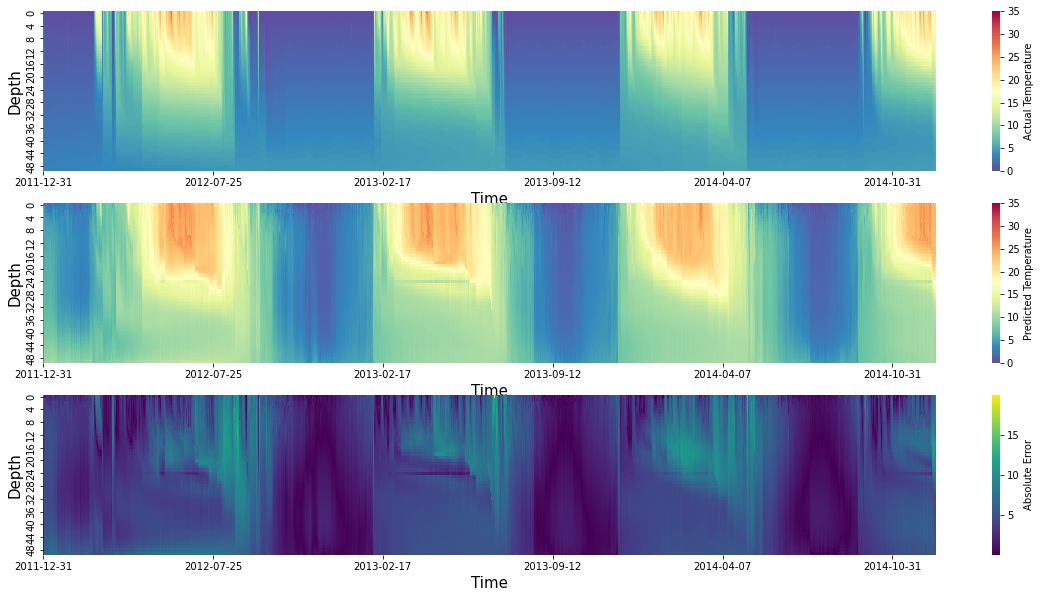

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

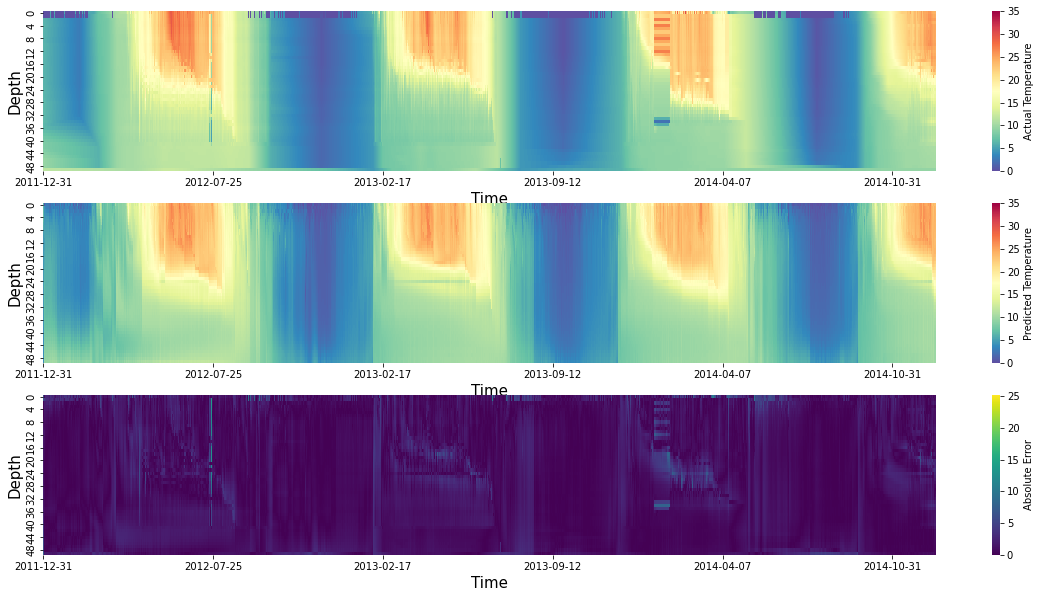

In [38]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [39]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0090550585
RMSE of after m1 0.016522184
RMSE of after m3 5.3468084
RMSE of after m4 6.745584
RMSE of after m0 0.010058648
RMSE of after m1 0.016627615
RMSE of after m3 5.4188
RMSE of after m4 6.7671056
RMSE of after m0 0.011175206
RMSE of after m1 0.018848468
RMSE of after m3 5.139082
RMSE of after m4 6.425837
RMSE of after m0 0.011941654
RMSE of after m1 0.019957943
RMSE of after m3 5.0505457
RMSE of after m4 6.331895
RMSE of after m0 0.011727795
RMSE of after m1 0.02048253
RMSE of after m3 4.993736
RMSE of after m4 6.2912283
RMSE of after m0 0.010224279
RMSE of after m1 0.019635735
RMSE of after m3 4.988462
RMSE of after m4 6.320519
RMSE of after m0 0.008626026
RMSE of after m1 0.01620574
RMSE of after m3 5.0048957
RMSE of after m4 6.2775884
RMSE of after m0 0.009490272
RMSE of after m1 0.015358796
RMSE of after m3 5.0221767
RMSE of after m4 6.2452307
RMSE of after m0 0.010674276
RMSE of after m1 0.017634274
RMSE of after m3 5.0804205
RMSE of after m4 6.345472
RMSE

RMSE of after m1 0.009231579
RMSE of after m3 6.8238482
RMSE of after m4 7.1367393
RMSE of after m0 0.007778761
RMSE of after m1 0.0056183287
RMSE of after m3 7.180041
RMSE of after m4 7.1440744
RMSE of after m0 0.0108512975
RMSE of after m1 0.011498152
RMSE of after m3 8.129722
RMSE of after m4 7.4736514
RMSE of after m0 0.012035362
RMSE of after m1 0.013494207
RMSE of after m3 9.679846
RMSE of after m4 8.346034
RMSE of after m0 0.010086248
RMSE of after m1 0.014489152
RMSE of after m3 9.870239
RMSE of after m4 8.413425
RMSE of after m0 0.010526003
RMSE of after m1 0.013280552
RMSE of after m3 8.91002
RMSE of after m4 7.9132533
RMSE of after m0 0.0064165476
RMSE of after m1 0.007993938
RMSE of after m3 7.300682
RMSE of after m4 7.0350513
RMSE of after m0 0.008246826
RMSE of after m1 0.009450231
RMSE of after m3 6.8127036
RMSE of after m4 6.6042514
RMSE of after m0 0.00856832
RMSE of after m1 0.008942973
RMSE of after m3 6.399427
RMSE of after m4 6.3318305
RMSE of after m0 0.0080105355

RMSE of after m1 0.015806895
RMSE of after m3 1.9210871
RMSE of after m4 1.8166301
RMSE of after m0 0.016523397
RMSE of after m1 0.014103757
RMSE of after m3 1.9787643
RMSE of after m4 1.8672804
RMSE of after m0 0.017184312
RMSE of after m1 0.016877146
RMSE of after m3 1.9381849
RMSE of after m4 1.85723
RMSE of after m0 0.017148841
RMSE of after m1 0.018557394
RMSE of after m3 1.7662742
RMSE of after m4 1.6918298
RMSE of after m0 0.016075712
RMSE of after m1 0.0139965415
RMSE of after m3 1.6014478
RMSE of after m4 1.541635
RMSE of after m0 0.017038234
RMSE of after m1 0.016146246
RMSE of after m3 1.5907052
RMSE of after m4 1.5280751
RMSE of after m0 0.018228516
RMSE of after m1 0.020548288
RMSE of after m3 2.1967926
RMSE of after m4 2.0559978
RMSE of after m0 0.01613603
RMSE of after m1 0.03826632
RMSE of after m3 2.2157805
RMSE of after m4 2.1490848
RMSE of after m0 0.016643256
RMSE of after m1 0.037973575
RMSE of after m3 2.0324376
RMSE of after m4 1.9661465
RMSE of after m0 0.016727

RMSE of after m3 1.7949406
RMSE of after m4 1.5630383
RMSE of after m0 0.021282943
RMSE of after m1 0.024494639
RMSE of after m3 1.6904892
RMSE of after m4 1.4778872
RMSE of after m0 0.020015152
RMSE of after m1 0.026169999
RMSE of after m3 1.7037833
RMSE of after m4 1.4826052
RMSE of after m0 0.017644184
RMSE of after m1 0.023409275
RMSE of after m3 1.8031068
RMSE of after m4 1.568836
RMSE of after m0 0.018936766
RMSE of after m1 0.02307606
RMSE of after m3 1.9819696
RMSE of after m4 1.7197765
RMSE of after m0 0.02063127
RMSE of after m1 0.026589442
RMSE of after m3 2.044405
RMSE of after m4 1.7717954
RMSE of after m0 0.02648403
RMSE of after m1 0.026995642
RMSE of after m3 1.8817874
RMSE of after m4 1.6217202
RMSE of after m0 0.025414173
RMSE of after m1 0.031857744
RMSE of after m3 1.7808867
RMSE of after m4 1.5340079
RMSE of after m0 0.022569383
RMSE of after m1 0.030776136
RMSE of after m3 1.796451
RMSE of after m4 1.5317334
RMSE of after m0 0.022294646
RMSE of after m1 0.03174847

RMSE of after m1 0.007246529
RMSE of after m3 3.5332575
RMSE of after m4 3.4950314
RMSE of after m0 0.007981351
RMSE of after m1 0.00666952
RMSE of after m3 3.6374521
RMSE of after m4 3.622041
RMSE of after m0 0.007361801
RMSE of after m1 0.0063784816
RMSE of after m3 3.5814998
RMSE of after m4 3.5851102
RMSE of after m0 0.009520466
RMSE of after m1 0.007336808
RMSE of after m3 3.6003227
RMSE of after m4 3.552447
RMSE of after m0 0.009104912
RMSE of after m1 0.0076103723
RMSE of after m3 3.6038656
RMSE of after m4 3.56339
RMSE of after m0 0.008567678
RMSE of after m1 0.008075513
RMSE of after m3 3.532573
RMSE of after m4 3.5367496
RMSE of after m0 0.009218525
RMSE of after m1 0.00795007
RMSE of after m3 3.463568
RMSE of after m4 3.4810889
RMSE of after m0 0.0074404776
RMSE of after m1 0.0071046026
RMSE of after m3 3.4823365
RMSE of after m4 3.5051558
RMSE of after m0 0.007875259
RMSE of after m1 0.009868602
RMSE of after m3 3.454843
RMSE of after m4 3.4990995
RMSE of after m0 0.0066567

RMSE of after m1 0.016130693
RMSE of after m3 5.1477427
RMSE of after m4 6.047576
RMSE of after m0 0.008612632
RMSE of after m1 0.013468146
RMSE of after m3 5.247394
RMSE of after m4 6.0742645
RMSE of after m0 0.011547579
RMSE of after m1 0.017422931
RMSE of after m3 5.426382
RMSE of after m4 6.29148
RMSE of after m0 0.011785709
RMSE of after m1 0.01916541
RMSE of after m3 5.2906604
RMSE of after m4 6.1498594
RMSE of after m0 0.010154073
RMSE of after m1 0.018130828
RMSE of after m3 5.1283946
RMSE of after m4 5.976174
RMSE of after m0 0.01001947
RMSE of after m1 0.018891497
RMSE of after m3 5.098267
RMSE of after m4 5.94749
RMSE of after m0 0.011390952
RMSE of after m1 0.02117092
RMSE of after m3 5.160201
RMSE of after m4 6.042106
RMSE of after m0 0.011197703
RMSE of after m1 0.019880833
RMSE of after m3 5.218233
RMSE of after m4 5.9866886
RMSE of after m0 0.0106218625
RMSE of after m1 0.020096842
RMSE of after m3 4.989194
RMSE of after m4 5.708999
RMSE of after m0 0.010949679
RMSE of 

RMSE of after m1 0.012746736
RMSE of after m3 6.402641
RMSE of after m4 6.98621
RMSE of after m0 0.008878538
RMSE of after m1 0.013399427
RMSE of after m3 6.030223
RMSE of after m4 6.648834
RMSE of after m0 0.009287463
RMSE of after m1 0.015470247
RMSE of after m3 5.773858
RMSE of after m4 6.40251
RMSE of after m0 0.009328958
RMSE of after m1 0.015242681
RMSE of after m3 5.6195846
RMSE of after m4 6.2463913
RMSE of after m0 0.009002721
RMSE of after m1 0.015990578
RMSE of after m3 5.532138
RMSE of after m4 6.1724305
RMSE of after m0 0.008544886
RMSE of after m1 0.01617208
RMSE of after m3 5.4539723
RMSE of after m4 6.118647
RMSE of after m0 0.008575589
RMSE of after m1 0.014104547
RMSE of after m3 5.6209626
RMSE of after m4 6.1916337
RMSE of after m0 0.008933899
RMSE of after m1 0.015201568
RMSE of after m3 5.50803
RMSE of after m4 6.091631
RMSE of after m0 0.00943008
RMSE of after m1 0.015018497
RMSE of after m3 5.2894454
RMSE of after m4 5.835199
RMSE of after m0 0.011259137
RMSE of 

RMSE of after m3 4.4081097
RMSE of after m4 3.8967903
RMSE of after m0 0.017712705
RMSE of after m1 0.019669158
RMSE of after m3 4.364724
RMSE of after m4 3.8482528
RMSE of after m0 0.017409895
RMSE of after m1 0.019808227
RMSE of after m3 4.186327
RMSE of after m4 3.7100842
RMSE of after m0 0.016961727
RMSE of after m1 0.017332457
RMSE of after m3 3.7614686
RMSE of after m4 3.3859289
RMSE of after m0 0.016568886
RMSE of after m1 0.01852086
RMSE of after m3 3.658123
RMSE of after m4 3.307137
RMSE of after m0 0.01738972
RMSE of after m1 0.018313559
RMSE of after m3 3.515155
RMSE of after m4 3.1958969
RMSE of after m0 0.020610489
RMSE of after m1 0.020166954
RMSE of after m3 3.442825
RMSE of after m4 3.1246138
RMSE of after m0 0.022032842
RMSE of after m1 0.021262817
RMSE of after m3 3.4809663
RMSE of after m4 3.132854
RMSE of after m0 0.020635437
RMSE of after m1 0.020230047
RMSE of after m3 3.3900394
RMSE of after m4 3.0637865
RMSE of after m0 0.020677224
RMSE of after m1 0.020527778
R

RMSE of after m1 0.02718351
RMSE of after m3 0.79285866
RMSE of after m4 0.7029432
RMSE of after m0 0.021844607
RMSE of after m1 0.02529575
RMSE of after m3 0.8016643
RMSE of after m4 0.7131719
RMSE of after m0 0.024181297
RMSE of after m1 0.025586048
RMSE of after m3 0.8279914
RMSE of after m4 0.7430225
RMSE of after m0 0.028725252
RMSE of after m1 0.027050585
RMSE of after m3 0.779572
RMSE of after m4 0.7003739
RMSE of after m0 0.029074952
RMSE of after m1 0.027694253
RMSE of after m3 0.7458601
RMSE of after m4 0.66849685
RMSE of after m0 0.025672523
RMSE of after m1 0.0256987
RMSE of after m3 0.8380831
RMSE of after m4 0.74891824
RMSE of after m0 0.02208245
RMSE of after m1 0.024560647
RMSE of after m3 0.7657705
RMSE of after m4 0.6805927
RMSE of after m0 0.021419208
RMSE of after m1 0.024929639
RMSE of after m3 0.85587
RMSE of after m4 0.7612293
RMSE of after m0 0.023166534
RMSE of after m1 0.025001964
RMSE of after m3 0.8814469
RMSE of after m4 0.78683746
RMSE of after m0 0.021650

RMSE of after m1 0.0071264775
RMSE of after m3 2.0432723
RMSE of after m4 2.1171098
RMSE of after m0 0.00839412
RMSE of after m1 0.0077062263
RMSE of after m3 2.0413158
RMSE of after m4 2.1264892
RMSE of after m0 0.008639388
RMSE of after m1 0.011443795
RMSE of after m3 2.4271188
RMSE of after m4 2.2666297
RMSE of after m0 0.009536335
RMSE of after m1 0.01519691
RMSE of after m3 3.6138773
RMSE of after m4 2.7490811
RMSE of after m0 0.0063060857
RMSE of after m1 0.009314442
RMSE of after m3 3.627051
RMSE of after m4 2.7193522
RMSE of after m0 0.0085289795
RMSE of after m1 0.008711449
RMSE of after m3 2.5087128
RMSE of after m4 2.3871562
RMSE of after m0 0.008736256
RMSE of after m1 0.0097516095
RMSE of after m3 2.301425
RMSE of after m4 2.3095806
RMSE of after m0 0.0082190605
RMSE of after m1 0.010800591
RMSE of after m3 2.424346
RMSE of after m4 2.3981853
RMSE of after m0 0.0075168894
RMSE of after m1 0.01038038
RMSE of after m3 2.5616589
RMSE of after m4 2.462599
RMSE of after m0 0.00

RMSE of after m0 0.008643506
RMSE of after m1 0.010902362
RMSE of after m3 4.4098477
RMSE of after m4 5.272645
RMSE of after m0 0.008717071
RMSE of after m1 0.012352541
RMSE of after m3 4.6085167
RMSE of after m4 5.527938
RMSE of after m0 0.009420361
RMSE of after m1 0.013959873
RMSE of after m3 4.5950317
RMSE of after m4 5.5552964
RMSE of after m0 0.017014742
RMSE of after m1 0.023894068
RMSE of after m3 4.584735
RMSE of after m4 5.681662
RMSE of after m0 0.009588451
RMSE of after m1 0.018617515
RMSE of after m3 4.4821277
RMSE of after m4 5.622575
RMSE of after m0 0.008172966
RMSE of after m1 0.016760927
RMSE of after m3 4.4833236
RMSE of after m4 5.5860415
RMSE of after m0 0.008411063
RMSE of after m1 0.013968216
RMSE of after m3 4.580843
RMSE of after m4 5.6642165
RMSE of after m0 0.00971563
RMSE of after m1 0.015768103
RMSE of after m3 4.605527
RMSE of after m4 5.725524
RMSE of after m0 0.011323469
RMSE of after m1 0.017906269
RMSE of after m3 4.541012
RMSE of after m4 5.6674953
RM

RMSE of after m3 4.683741
RMSE of after m4 5.8612375
RMSE of after m0 0.009690744
RMSE of after m1 0.015705017
RMSE of after m3 4.7640634
RMSE of after m4 5.9879656
RMSE of after m0 0.010445562
RMSE of after m1 0.017995266
RMSE of after m3 4.790522
RMSE of after m4 6.034237
RMSE of after m0 0.010001367
RMSE of after m1 0.01746396
RMSE of after m3 4.7214003
RMSE of after m4 5.8948393
RMSE of after m0 0.00949799
RMSE of after m1 0.015747735
RMSE of after m3 4.766315
RMSE of after m4 5.9025416
RMSE of after m0 0.009359009
RMSE of after m1 0.013428353
RMSE of after m3 4.8643284
RMSE of after m4 6.0326304
RMSE of after m0 0.008758241
RMSE of after m1 0.013459512
RMSE of after m3 5.6537557
RMSE of after m4 6.8361936
RMSE of after m0 0.008512282
RMSE of after m1 0.014327376
RMSE of after m3 5.8793035
RMSE of after m4 7.038871
RMSE of after m0 0.008112459
RMSE of after m1 0.0153117385
RMSE of after m3 5.8809376
RMSE of after m4 7.034001
RMSE of after m0 0.0073787696
RMSE of after m1 0.01429484

RMSE of after m4 8.3676
RMSE of after m0 0.012205499
RMSE of after m1 0.01207466
RMSE of after m3 9.163409
RMSE of after m4 7.8559732
RMSE of after m0 0.015493339
RMSE of after m1 0.018169297
RMSE of after m3 9.90728
RMSE of after m4 8.261204
RMSE of after m0 0.0151820695
RMSE of after m1 0.021076469
RMSE of after m3 10.378104
RMSE of after m4 8.4189205
RMSE of after m0 0.016421856
RMSE of after m1 0.041646767
RMSE of after m3 7.8075123
RMSE of after m4 6.4157906
RMSE of after m0 0.015822817
RMSE of after m1 0.020757953
RMSE of after m3 7.692666
RMSE of after m4 6.3500156
RMSE of after m0 0.019119844
RMSE of after m1 0.025252035
RMSE of after m3 7.5221057
RMSE of after m4 6.242594
RMSE of after m0 0.019085782
RMSE of after m1 0.024508202
RMSE of after m3 7.593003
RMSE of after m4 6.25253
RMSE of after m0 0.016752798
RMSE of after m1 0.02025835
RMSE of after m3 7.3297772
RMSE of after m4 6.0831804
RMSE of after m0 0.015985588
RMSE of after m1 0.020832816
RMSE of after m3 7.47177
RMSE of

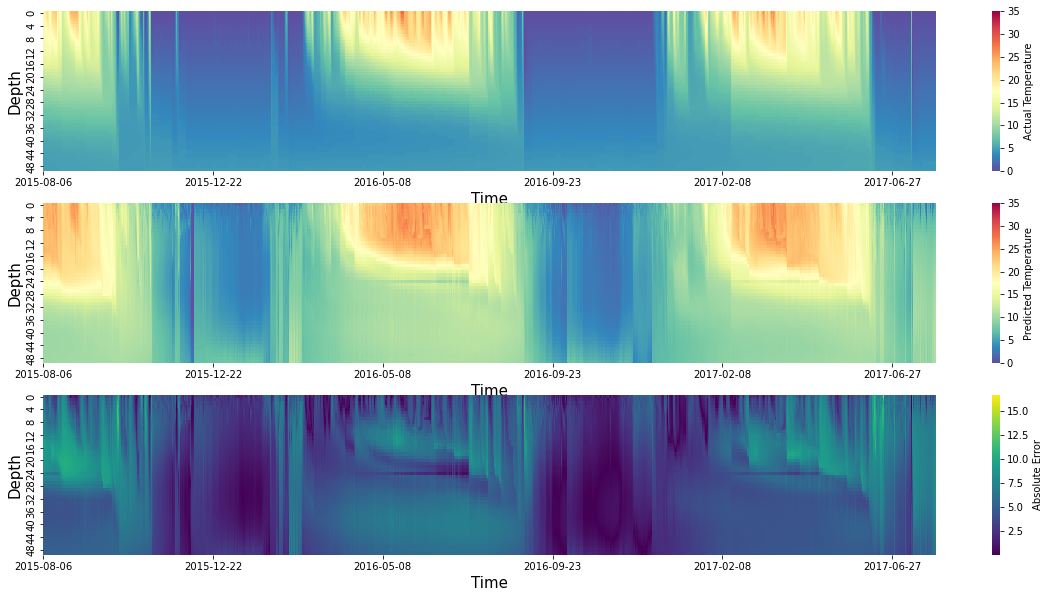

In [40]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

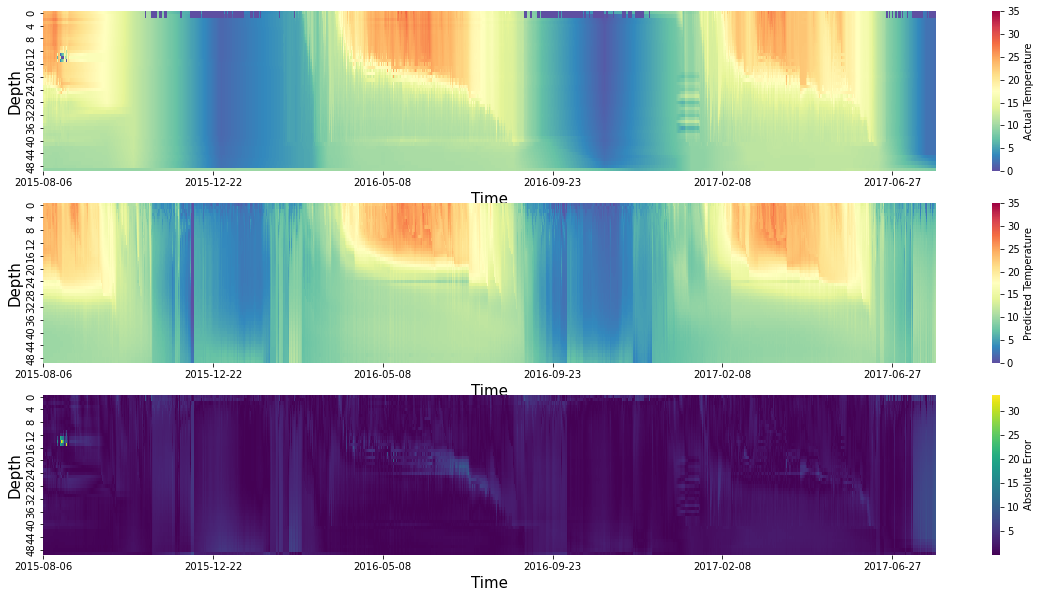

In [41]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [42]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.555871016901205, Train L2 Error: 0.5999380529779642
Test RMSE: 4.81928660966558, Train L2 Error: 0.605854504720045


## Mixing Model

## Convection Model

In [43]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.016564466585520927, Train L2 Error: 0.0021814161585095035
Test RMSE: 0.018082867571663358, Train L2 Error: 0.0022734152265340805


## Ice Model

In [44]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014016497076078948, Train L2 Error: 0.0018445259825475508
Test RMSE: 0.01633510608431941, Train L2 Error: 0.0020521246787989266


# Compute Model Similarity after Finetuning

In [45]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [46]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [47]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.8987851738929749
L2 Norm: 8.128643035888672


In [48]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [49]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [50]:
# Freeze all models again and compute finetuned diffusivity values

In [51]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [52]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [53]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

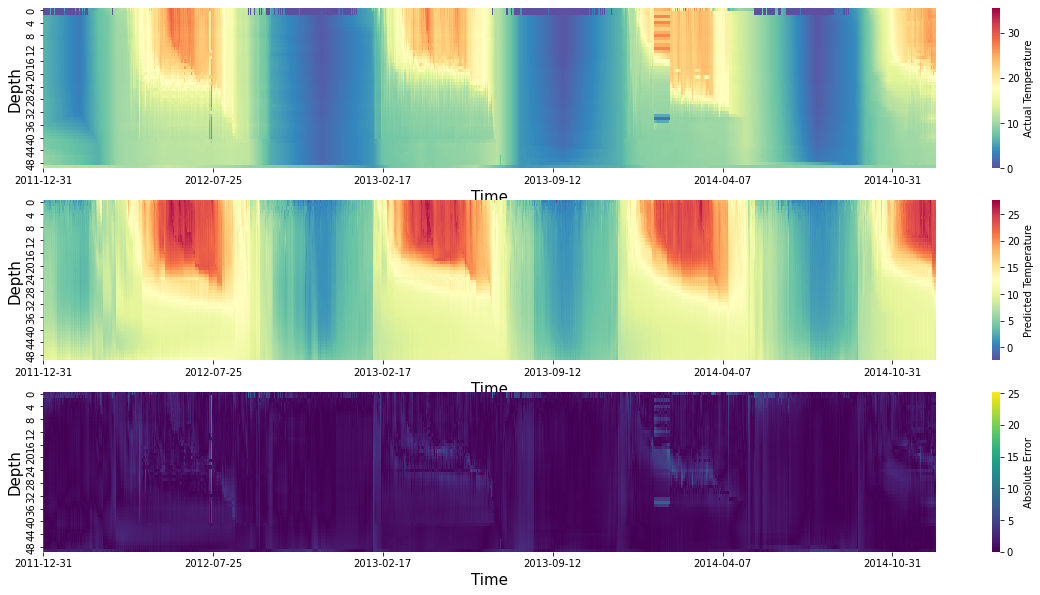

In [54]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

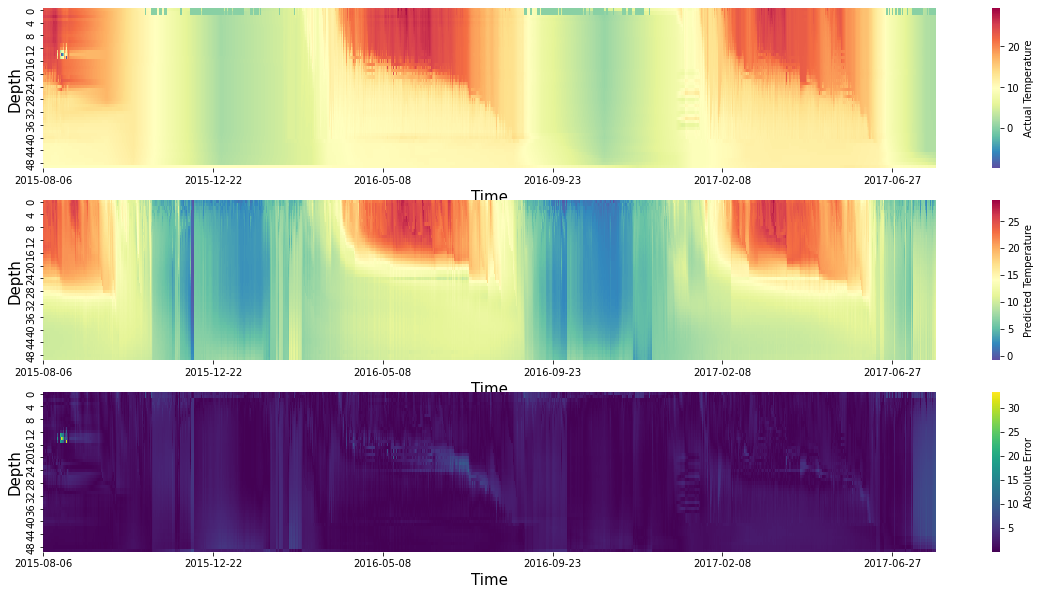

In [55]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))